In [ ]:
pip install arch


In [ ]:
# https://github.com/elhamidimed/Markowitz-Portfolio-optimisation-Genetic-algorithm/blob/main/main.ipynb
#Useful link for portfolio optimisation

In [ ]:
#https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/
#Useful link for GARCH !


In [181]:
import pandas as pd
import numpy as np
from IPython.display import Image
import scipy.stats as st
from scipy.stats import kstest
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import shapiro
from arch import arch_model
from scipy.stats import chi2
from scipy.optimize import minimize


import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings

from scipy.stats import genextreme as gev





In [182]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4


In [183]:
SP500 = pd.read_excel('/Users/enzorua/Desktop/EMF/Project 2/S&P 500.xlsx')
SMI = pd.read_excel('/Users/enzorua/Desktop/EMF/Project 2/SMI.xlsx')
US_deposit = pd.read_excel('/Users/enzorua/Desktop/EMF/Project 2/us short term deposit.xlsx')


SP500['DATE'] = pd.to_datetime(SP500['DATE'])
SP500.set_index('DATE',inplace = True)

SMI['DATE'] = pd.to_datetime(SMI['DATE'])
SMI.set_index('DATE',inplace = True)

US_deposit['Date'] = pd.to_datetime(US_deposit['Date'])
US_deposit.set_index('Date',inplace = True)

SP500_returns = SP500.pct_change()
SP500_returns = SP500_returns.apply(lambda x : x.fillna(x.mean()),axis = 0)


SMI_returns = SMI.pct_change()
SMI_returns = SMI_returns.apply(lambda x : x.fillna(x.mean()),axis = 0)

US_deposit = US_deposit/5200 # to get in % and weekly

# Static allocation

In [184]:
#Definition des variables

#u
expected_returnsSP500 = SP500_returns['S&P 500'].mean()
expected_returnsSMI = SMI_returns['SMI'].mean()
u= np.array([expected_returnsSP500,expected_returnsSMI])
u = u.reshape((2,1))

#e
#e =np.ones(2)
e =np.ones((2,1))


# cov
SP500_return_values = SP500_returns['S&P 500'].values
SMI_return_values = SMI_returns['SMI'].values
combined_returns = np.column_stack((SP500_return_values, SMI_return_values))
cov = np.cov(combined_returns, rowvar=False)
cov_inverse = np.linalg.inv(cov)


#Je prend l'average du risk free rate
rf = US_deposit['US DOLLAR S/T DEPOSIT (FT/RFV) - MIDDLE RATE'].mean()




## 1.2) optimal weight for lambda = 2

In [185]:
lambda_ = 2

mu = u

Sigma_inv = cov_inverse

adjusted_mu = mu -rf*e

alpha_tilde2 = (1 / lambda_) * Sigma_inv.dot(adjusted_mu)



# Création d'un array avec la même paire de valeurs répétée 1200 fois
num_rows = 1200  # Nombre de lignes souhaitées
weights = np.array([0.7700108, 0.42559668] * num_rows).reshape(num_rows, 2)

# Création du DataFrame
weights_static_2 = pd.DataFrame(weights, columns=['Stock Weight', 'Bond Weight'])



weights_static_2.index = SP500.index

weights_static_2



,Stock Weight,Bond Weight
DATE,,
2001-01-01,0.770011,0.425597
2001-01-08,0.770011,0.425597
2001-01-15,0.770011,0.425597
2001-01-22,0.770011,0.425597
2001-01-29,0.770011,0.425597
...,...,...
2023-11-27,0.770011,0.425597
2023-12-04,0.770011,0.425597
2023-12-11,0.770011,0.425597


## 1.2) Optimal weight for lambda = 10

In [186]:
lambda_ = 10

mu = u

Sigma_inv = cov_inverse

adjusted_mu = mu -rf*e

alpha_tilde10 = (1 / lambda_) * Sigma_inv.dot(adjusted_mu)



# Création d'un array avec la même paire de valeurs répétée 1200 fois
num_rows = 1200  # Nombre de lignes souhaitées
weights = np.array([0.15400216, 0.08511934] * num_rows).reshape(num_rows, 2)

# Création du DataFrame
weights_static_10 = pd.DataFrame(weights, columns=['Stock Weight', 'Bond Weight'])



weights_static_10.index = SP500.index


weights_static_10

,Stock Weight,Bond Weight
DATE,,
2001-01-01,0.154002,0.085119
2001-01-08,0.154002,0.085119
2001-01-15,0.154002,0.085119
2001-01-22,0.154002,0.085119
2001-01-29,0.154002,0.085119
...,...,...
2023-11-27,0.154002,0.085119
2023-12-04,0.154002,0.085119
2023-12-11,0.154002,0.085119


# 2 Estimation of a GARCH model

## Kolmogorov-Smirnov test

In [187]:
SP500_excess_returns = SP500_returns-rf
SMI_excess_returns = SMI_returns - rf

SP500_exess_returns_squared = SP500_excess_returns**2
SMI_excess_returns_squared = SMI_excess_returns**2

In [188]:
#I set the values in serie as it is easier to then compute the test
SP500_returns_series = SP500_excess_returns['S&P 500']
SMI_excess_returns_series = SMI_excess_returns['SMI']

SP500_exess_returns_squared_series = SP500_exess_returns_squared['S&P 500']
SMI_excess_returns_squared_series = SMI_excess_returns_squared['SMI']



In [189]:
#ks test for SP500 excess return

ks_stat_stock, ks_pvalue_stock = kstest(SP500_returns_series, 'norm', args=(SP500_returns_series.mean(), SP500_returns_series.std()))
print("Kolmogorov-Smirnov test for stock returns:", ks_stat_stock, ks_pvalue_stock)

#As shown by the p value which is 5.9165818934492544e-08 so extremelly low


Kolmogorov-Smirnov test for stock returns: 0.08479129238453625 5.916581893449389e-08


In [190]:
#ks test for SMI excess return
ks_stat_SMI, ks_pvalue_SMI = kstest(SMI_excess_returns_series, 'norm', args=(SMI_excess_returns_series.mean(), SMI_excess_returns_series.std()))
print("Kolmogorov-Smirnov test for stock returns:", ks_stat_SMI, ks_pvalue_SMI)


Kolmogorov-Smirnov test for stock returns: 0.07190839734813062 7.68052326095091e-06


In [191]:
#ks test for SP500 squared excess return
ks_stat_stock_squared, ks_pvalue_stock_squared = kstest(SP500_exess_returns_squared_series, 'norm', args=(SP500_exess_returns_squared_series.mean(), SP500_exess_returns_squared_series.std()))
print("Kolmogorov-Smirnov test for stock returns:", ks_stat_stock_squared, ks_pvalue_stock_squared)


Kolmogorov-Smirnov test for stock returns: 0.35865989050854763 1.043402771141358e-138


In [192]:
#ks test for SMI squared excess return
ks_stat_SMI_squared, ks_pvalue_SMI_squared = kstest(SMI_excess_returns_squared_series, 'norm', args=(SMI_excess_returns_squared_series.mean(), SMI_excess_returns_squared_series.std()))
print("Kolmogorov-Smirnov test for stock returns:", ks_stat_SMI_squared, ks_pvalue_SMI_squared)

Kolmogorov-Smirnov test for stock returns: 0.3392516655679197 9.74978563344558e-124


## Ljung-Box test with 4 lags

In [193]:
# Ljung_box for SP500 excess return

lb_stock = acorr_ljungbox(SP500_returns_series, lags=[4], return_df=True)
print("Ljung-Box Test on SP500 excess return:")
print(lb_stock)

# here the p_values is 0.077 > 0.05
# no strong evidence of autocorrelation of SP500
#Verifier etand donner que la suite de la consigne suggere d'evincer l'autocorrelation (bizarre)


Ljung-Box Test on SP500 excess return:
    lb_stat  lb_pvalue
4  8.439863   0.076731


In [194]:
# Ljung_box for SMI excess return

lb_smi = acorr_ljungbox(SMI_excess_returns_series, lags=[4], return_df=True)
print("Ljung-Box Test on SMI excess return:")
print(lb_smi)

# here p-values is under 0.05, raisonnement inverse d'avant

Ljung-Box Test on SMI excess return:
    lb_stat  lb_pvalue
4  9.784003   0.044228


In [195]:
lb_stock_squared = acorr_ljungbox(SP500_exess_returns_squared_series, lags = [4], return_df = True)
print("Ljung-Box Test on stock squared excess return:")
print(lb_stock_squared)

Ljung-Box Test on stock squared excess return:
      lb_stat     lb_pvalue
4  363.840152  1.800430e-77


In [196]:
lb_smi_squared = acorr_ljungbox(SMI_excess_returns_squared_series, lags = [4], return_df = True)
print("Ljung-Box Test on smi squared excess return:")
print(lb_smi_squared)

Ljung-Box Test on smi squared excess return:
      lb_stat     lb_pvalue
4  273.530104  5.531357e-58


## 2.2 Estimation AR(1) model

In [197]:
#AR(1) model for stocks

AR1_stocks = AutoReg(SP500_returns, lags = 1)
AR1_stocks_fit = AR1_stocks.fit() #Utilisation () pour preciser l'appel de la methode sinon ca marche pas


print(AR1_stocks_fit.summary())

#Verifier aupres de l'asistante EMF etant donner que la fonction AutoReg estime par elle meme de maniere 
#hebdomadaire
#Durant la correction, elle nous a parler de la fonction ffil, est ce que on doit l'utiliser ici ?


# Extraction des résidus
residuals_stocks = AR1_stocks_fit.resid

# Statistiques descriptives des résidus
print(residuals_stocks.describe())



                            AutoReg Model Results                             
Dep. Variable:                S&P 500   No. Observations:                 1200
Model:                     AutoReg(1)   Log Likelihood                2687.673
Method:               Conditional MLE   S.D. of innovations              0.026
Date:                Fri, 24 May 2024   AIC                          -5369.345
Time:                        00:06:22   BIC                          -5354.078
Sample:                    01-08-2001   HQIC                         -5363.594
                         - 12-25-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      2.564      0.010       0.000       0.003
S&P 500.L1    -0.0774      0.029     -2.689      0.007      -0.134      -0.021
                                    Roots           

In [198]:
# AR(1) model for bond

AR1_bond = AutoReg(SMI_returns, lags = 1)
AR1_bond_fit = AR1_bond.fit() #Utilisation () pour preciser l'appel de la methode sinon ca marche pas


print(AR1_bond_fit.summary())

# Extraction des résidus
residuals_bond = AR1_bond_fit.resid

# Statistiques descriptives des résidus
print(residuals_bond.describe())



                            AutoReg Model Results                             
Dep. Variable:                    SMI   No. Observations:                 1200
Model:                     AutoReg(1)   Log Likelihood                2681.187
Method:               Conditional MLE   S.D. of innovations              0.026
Date:                Fri, 24 May 2024   AIC                          -5356.374
Time:                        00:06:23   BIC                          -5341.106
Sample:                    01-08-2001   HQIC                         -5350.623
                         - 12-25-2023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.001      2.376      0.017       0.000       0.003
SMI.L1        -0.0697      0.029     -2.419      0.016      -0.126      -0.013
                                    Roots           

## 2.3 Estimation of GARCH model

In [199]:
# https://medium.com/@Teckk/volatility-modelling-and-coding-garch-1-1-in-python-a89c75f3e010 (useful link)

## GARCH(1,1) SP500

In [200]:

garch_stock = arch_model(residuals_stocks,mean ='Zero', vol = 'Garch',p =1, q =1)
garch_stock_fit = garch_stock.fit(disp='off')
print(garch_stock_fit.summary())

#Pour repondre au message d'alerte, il faudrait rescale les residuals, a verifier avec l'assistante
#rescaled_residuals = 100 * residuals

# Extraction des paramètres
params = garch_stock_fit.params
alpha, beta = params['alpha[1]'], params['beta[1]']

# Test de Wald
test_stat = (alpha + beta - 1)**2 / (garch_stock_fit.param_cov.loc['alpha[1]', 'alpha[1]'] + garch_stock_fit.param_cov.loc['beta[1]', 'beta[1]'] + 2 * garch_stock_fit.param_cov.loc['alpha[1]', 'beta[1]'])
p_value = 1 - chi2.cdf(test_stat, df=1)  # df=1 car un seul paramètre testé

print(f'Test Statistic: {test_stat}')
print(f'P-Value: {p_value}')


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2894.42
Distribution:                  Normal   AIC:                          -5782.83
Method:            Maximum Likelihood   BIC:                          -5767.57
                                        No. Observations:                 1199
Date:                Fri, May 24 2024   Df Residuals:                     1199
Time:                        00:06:25   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.3229e-05  1.930e-11  6.854e+05      0.000 [1.

## GARCH(1,1) SMI

In [201]:

garch_bond = arch_model(residuals_bond,mean ='Zero', vol = 'Garch',p =1, q =1)
garch_bond_fit = garch_bond.fit(disp='off')
print(garch_bond_fit.summary())

#Pour repondre au message d'alerte, il faudrait rescale les residuals, a verifier avec l'assistante
#rescaled_residuals = 100 * residuals

# Extraction des paramètres
params = garch_bond_fit.params
alpha, beta = params['alpha[1]'], params['beta[1]']

# Test de Wald
test_stat = (alpha + beta - 1)**2 / (garch_bond_fit.param_cov.loc['alpha[1]', 'alpha[1]'] + garch_bond_fit.param_cov.loc['beta[1]', 'beta[1]'] + 2 * garch_bond_fit.param_cov.loc['alpha[1]', 'beta[1]'])
p_value = 1 - chi2.cdf(test_stat, df=1)  # df=1 car un seul paramètre testé

print(f'Test Statistic: {test_stat}')
print(f'P-Value: {p_value}')


                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:                2814.13
Distribution:                  Normal   AIC:                          -5622.25
Method:            Maximum Likelihood   BIC:                          -5606.99
                                        No. Observations:                 1199
Date:                Fri, May 24 2024   Df Residuals:                     1199
Time:                        00:06:26   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      6.6865e-05  1.891e-05      3.537  4.050e-04 [2.

# 3 Dynamic allocation

In [202]:
stocks_returns = SP500_returns['S&P 500']
bond_returns = SMI_returns['SMI']

# Fonction pour estimer le modèle AR(1)
def estimate_ar_model(returns):
    return AutoReg(returns, lags=1).fit()

# Fonction pour calculer le rendement attendu en utilisant les paramètres dynamiques du modèle AR(1)
def calculate_expected_return(ar_model, last_return):
    const = ar_model.params['const']
    rho = 0  # Initialisation par défaut de rho
    # Récupération dynamique du paramètre de retard
    for param in ar_model.params.index:
        if param.endswith('.L1'):
            rho = ar_model.params[param]
            break
    expected_return = const + rho * last_return
    return expected_return

# Fonction pour calculer les rendements attendus pour chaque période
def calculate_expected_returns(model, returns):
    expected_returns = []
    # Boucle sur toutes les valeurs sauf la première
    for i in range(1, len(returns)):
        last_return = returns.iloc[i-1]  # Rendement de la période précédente
        expected_return = calculate_expected_return(model, last_return)
        expected_returns.append(expected_return)
    return pd.Series(expected_returns, index=returns.index[1:])  # Série pandas pour les rendements attendus


# Estimation des modèles AR(1)
stock_ar_model = estimate_ar_model(SP500_returns)
bond_ar_model = estimate_ar_model(SMI_returns)

# Calcul des rendements attendus pour chaque période
stock_expected_returns = calculate_expected_returns(stock_ar_model, SP500_returns)
bond_expected_returns = calculate_expected_returns(bond_ar_model, SMI_returns)

def clean_data(value):
    if isinstance(value, str):
        return float(value.split()[0])
    return value  # Retourne la valeur telle quelle si ce n'est pas une chaîne

stock_expected_returns = stock_expected_returns.apply(clean_data)
bond_expected_returns = bond_expected_returns.apply(clean_data)

expected_returns = pd.merge(stock_expected_returns, bond_expected_returns, on = 'DATE' , how = 'inner' )



def estimate_ar_garch(returns):
    # Fit AR(1)
    ar_model = AutoReg(returns, lags=1).fit()
    # Get residuals for GARCH model
    residuals = ar_model.resid
    # Fit GARCH(1,1)
    garch_model = arch_model(residuals, vol='Garch', p=1, q=1, mean='zero').fit(disp='off')
    return ar_model, garch_model

def forecast_variance_garch(garch_model, residuals):
    # Get GARCH parameters
    omega, alpha, beta = garch_model.params['omega'], garch_model.params['alpha[1]'], garch_model.params['beta[1]']
    # List to store forecasted variances
    forecasted_variances = []
    # Loop through the residuals to compute forecasted variance for each date
    last_vol = garch_model.conditional_volatility.iloc[0] ** 2  # Initialize with the first volatility
    for resid in residuals:
        sigma_forecast = omega + alpha * (resid ** 2) + beta * last_vol
        forecasted_variances.append(sigma_forecast)
        last_vol = sigma_forecast  # Update last_vol to the current forecast for next iteration
    return forecasted_variances



# Estimating models
stock_ar_model, stock_garch_model = estimate_ar_garch(SP500_returns)
bond_ar_model, bond_garch_model = estimate_ar_garch(SMI_returns)

# Forecasting variances for each date
stock_variances = forecast_variance_garch(stock_garch_model, stock_ar_model.resid)
bond_variances = forecast_variance_garch(bond_garch_model, bond_ar_model.resid)

stock_variance_series = pd.Series(stock_variances, index=stocks_returns.index[1:])  # Start index from second element
bond_variance_series = pd.Series(bond_variances, index=bond_returns.index[1:])    # Same adjustment here


# Combine into a DataFrame
variance_df = pd.DataFrame({
    'Stock Variances': stock_variance_series,
    'Bond Variances': bond_variance_series
})

#variance_df


# Assuming you have already calculated the residuals as follows
stock_residuals = stock_ar_model.resid
bond_residuals = bond_ar_model.resid

# Ensure both residual series are aligned by date and have the same length
stock_residuals_aligned, bond_residuals_aligned = stock_residuals.align(bond_residuals, join='inner')

# Compute the correlation coefficient between the residuals
rho_sb = stock_residuals_aligned.corr(bond_residuals_aligned)


expected_covariance = rho_sb * np.sqrt(variance_df['Stock Variances']) * np.sqrt(variance_df['Bond Variances'])



# Creating a DataFrame to hold the covariance matrices
covariance_matrices = pd.DataFrame(index=variance_df.index, columns=['Covariance_Matrix'])

# Loop over each date to construct the covariance matrix
for date in variance_df.index:
    var_s = variance_df['Stock Variances'].loc[date]
    var_b = variance_df['Bond Variances'].loc[date]
    cov_sb = expected_covariance.loc[date]
    cov_matrix = np.array([[var_s, cov_sb], [cov_sb, var_b]])
    covariance_matrices.loc[date, 'Covariance_Matrix'] = cov_matrix
    
# Création d'un nouveau DataFrame pour stocker les matrices inversées
inverse_cov_matrices = pd.DataFrame(index=covariance_matrices.index, columns=['Inverse_Covariance_Matrix'])

# Calcul de l'inverse pour chaque matrice
for date, row in covariance_matrices.iterrows():
    matrix = np.array(row['Covariance_Matrix'])
    inverse_matrix = np.linalg.inv(matrix)  # Calcul de l'inverse
    inverse_cov_matrices.loc[date, 'Inverse_Covariance_Matrix'] = inverse_matrix

# Affichage du nouveau DataFrame avec les matrices inversées
#inverse_cov_matrices

## Optimal weight for lambda 2 and 10

In [203]:
mu = expected_returns
lambda_risk = 2
rf_dyn = US_deposit

# Initialiser le DataFrame pour stocker les poids optimaux
alpha_hats2 = pd.DataFrame(index=mu.index, columns=['Weight Stock', 'Weight Bond'])

for date in mu.index:
    mu_date = mu.loc[date].values.reshape(-1, 1)  # Rendements attendus pour la date, sous forme de vecteur colonne
    Rf_date = rf_dyn.loc[date].item()  # Assurez-vous que c'est un scalaire

    e = np.array([1, 1]).reshape(-1, 1)  # Vecteur de uns, vecteur colonne
    adjusted_returns = mu_date - Rf_date * e  # Ajustement pour le taux sans risque de la date, les dimensions doivent correspondre

    inv_cov_matrix = np.array(inverse_cov_matrices.loc[date].item())  # Matrice de covariance inverse pour la date, extraction correcte en tant que matrice

    # Calcul des poids
    weights = (1 / lambda_risk) * inv_cov_matrix.dot(adjusted_returns)
    alpha_hats2.loc[date] = weights.flatten()  # Flatten the result to fit into the DataFrame

alpha_hats2


,Weight Stock,Weight Bond
DATE,,
2001-01-08,0.554446,0.068145
2001-01-15,3.350672,-1.104504
2001-01-22,-6.517474,6.889606
2001-01-29,-3.295821,2.990828
2001-02-05,-1.477019,1.077759
...,...,...
2023-11-27,-0.51337,-1.222262
2023-12-04,2.140491,-1.553385
2023-12-11,2.886019,-2.785719


In [204]:

lambda_risk = 10

# Initialiser le DataFrame pour stocker les poids optimaux
alpha_hats10 = pd.DataFrame(index=mu.index, columns=['Weight Stock', 'Weight Bond'])

for date in mu.index:
    mu_date = mu.loc[date].values.reshape(-1, 1)  # Rendements attendus pour la date, sous forme de vecteur colonne
    Rf_date = rf_dyn.loc[date].item()  # Assurez-vous que c'est un scalaire

    e = np.array([1, 1]).reshape(-1, 1)  # Vecteur de uns, vecteur colonne
    adjusted_returns = mu_date - Rf_date * e  # Ajustement pour le taux sans risque de la date, les dimensions doivent correspondre

    inv_cov_matrix = np.array(inverse_cov_matrices.loc[date].item())  # Matrice de covariance inverse pour la date, extraction correcte en tant que matrice

    # Calcul des poids
    weights = (1 / lambda_risk) * inv_cov_matrix.dot(adjusted_returns)
    alpha_hats10.loc[date] = weights.flatten()  # Flatten the result to fit into the DataFrame

alpha_hats10


,Weight Stock,Weight Bond
DATE,,
2001-01-08,0.110889,0.013629
2001-01-15,0.670134,-0.220901
2001-01-22,-1.303495,1.377921
2001-01-29,-0.659164,0.598166
2001-02-05,-0.295404,0.215552
...,...,...
2023-11-27,-0.102674,-0.244452
2023-12-04,0.428098,-0.310677
2023-12-11,0.577204,-0.557144


## 3.1 Plot time serie of optimal weight

### Static

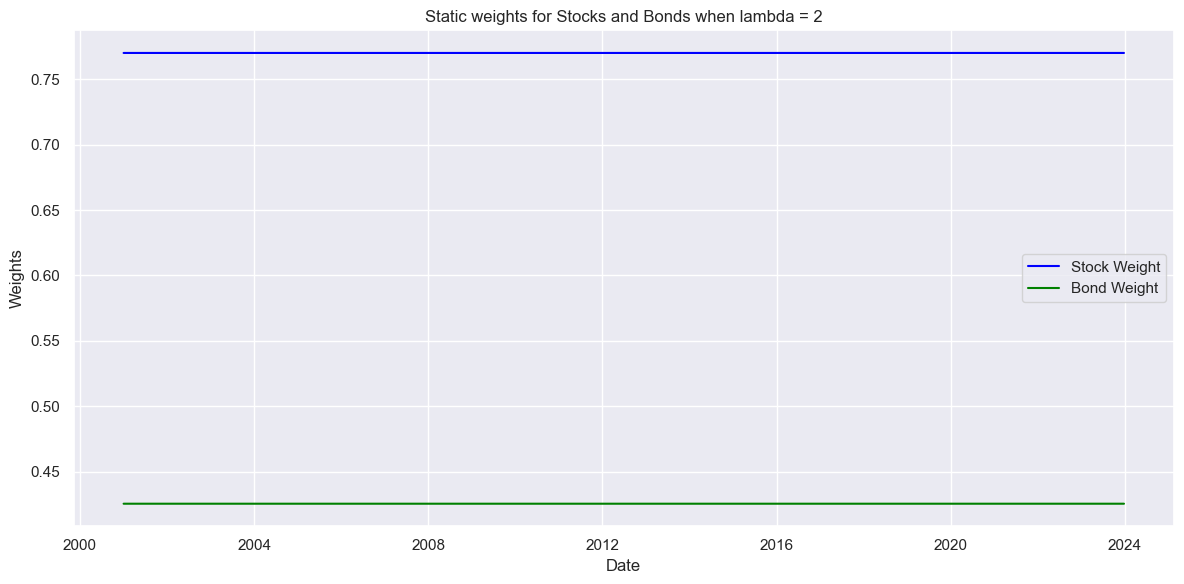

In [205]:
import matplotlib.pyplot as plt

# Assuming alpha_hats is already a DataFrame with a datetime index and columns 'Stock Weight' and 'Bond Weight'

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot stock weights
ax.plot(weights_static_2.index, weights_static_2['Stock Weight'], label='Stock Weight', color='blue')

# Plot bond weights
ax.plot(weights_static_2.index, weights_static_2['Bond Weight'], label='Bond Weight', color='green')

# Add title and labels
ax.set_title('Static weights for Stocks and Bonds when lambda = 2')
ax.set_xlabel('Date')
ax.set_ylabel('Weights')

# Add a legend
ax.legend()

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()


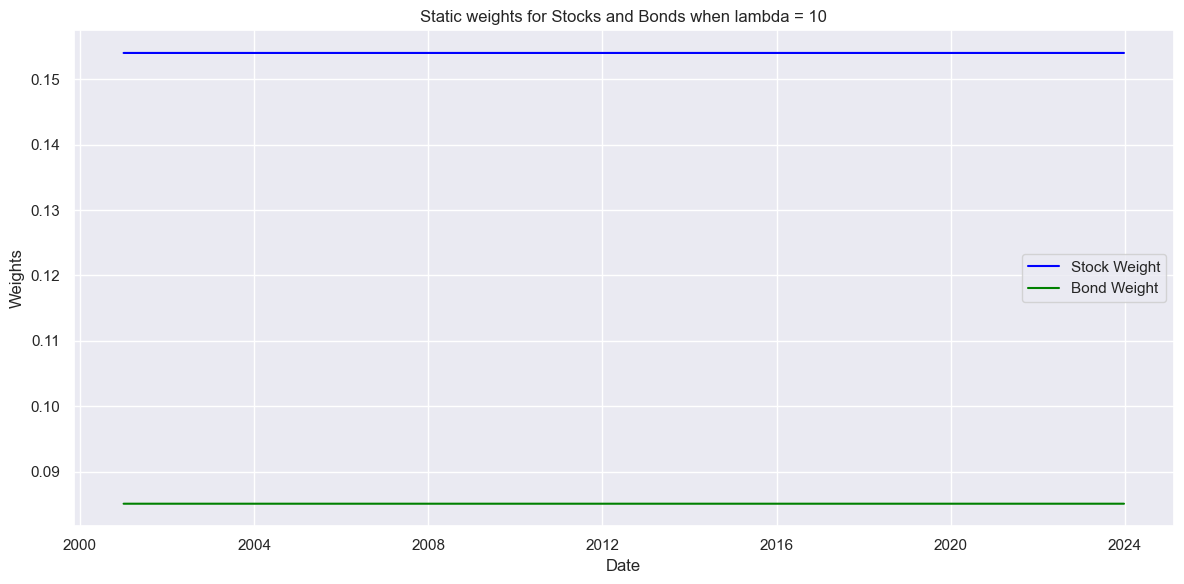

In [206]:
import matplotlib.pyplot as plt

# Assuming alpha_hats is already a DataFrame with a datetime index and columns 'Stock Weight' and 'Bond Weight'

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot stock weights
ax.plot(weights_static_10.index, weights_static_10['Stock Weight'], label='Stock Weight', color='blue')

# Plot bond weights
ax.plot(weights_static_10.index, weights_static_10['Bond Weight'], label='Bond Weight', color='green')

# Add title and labels
ax.set_title('Static weights for Stocks and Bonds when lambda = 10')
ax.set_xlabel('Date')
ax.set_ylabel('Weights')

# Add a legend
ax.legend()

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

### Dynamic

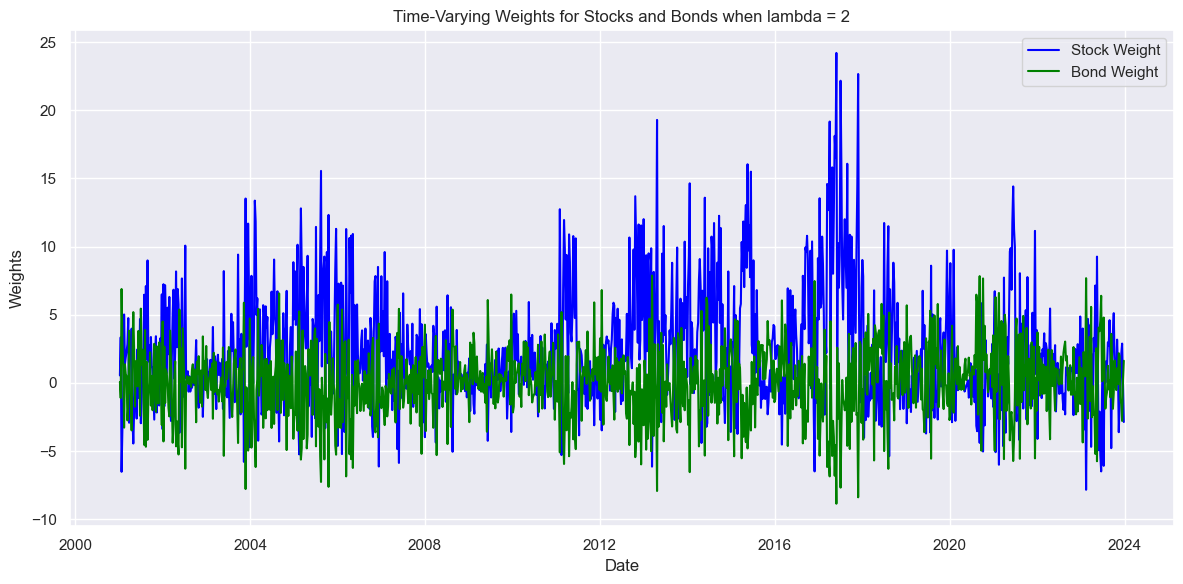

In [207]:
import matplotlib.pyplot as plt

# Assuming alpha_hats is already a DataFrame with a datetime index and columns 'Stock Weight' and 'Bond Weight'

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot stock weights
ax.plot(alpha_hats2.index, alpha_hats2['Weight Stock'], label='Stock Weight', color='blue')

# Plot bond weights
ax.plot(alpha_hats2.index, alpha_hats2['Weight Bond'], label='Bond Weight', color='green')

# Add title and labels
ax.set_title('Time-Varying Weights for Stocks and Bonds when lambda = 2')
ax.set_xlabel('Date')
ax.set_ylabel('Weights')

# Add a legend
ax.legend()

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()


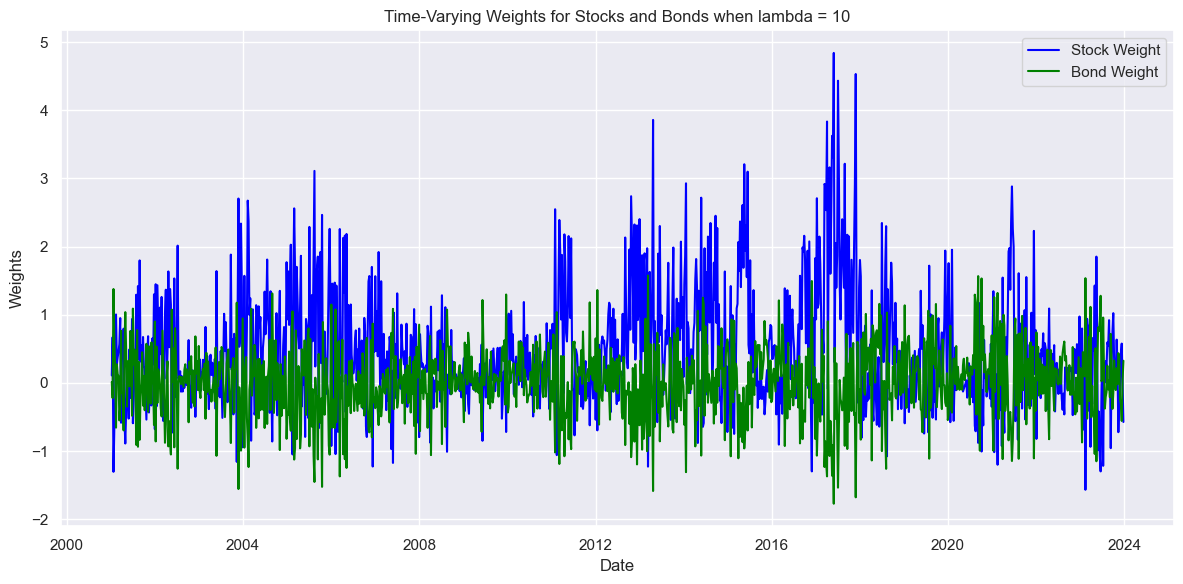

In [208]:
import matplotlib.pyplot as plt

# Assuming alpha_hats is already a DataFrame with a datetime index and columns 'Stock Weight' and 'Bond Weight'

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Plot stock weights
ax.plot(alpha_hats10.index, alpha_hats10['Weight Stock'], label='Stock Weight', color='blue')

# Plot bond weights
ax.plot(alpha_hats10.index, alpha_hats10['Weight Bond'], label='Bond Weight', color='green')

# Add title and labels
ax.set_title('Time-Varying Weights for Stocks and Bonds when lambda = 10')
ax.set_xlabel('Date')
ax.set_ylabel('Weights')

# Add a legend
ax.legend()

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()


## 3.2 Cumulative returns

### Static approach when lambda = 2

In [209]:
bond_returns = SMI_returns['SMI']
bond_weight = weights_static_2['Bond Weight']
bond_returns.index = pd.to_datetime(bond_returns.index)
bond_weight.index = pd.to_datetime(bond_weight.index)

alloc_bond = bond_weight*bond_returns # Ca represente l'allocation dans les bonds

stock_returns = SP500_returns['S&P 500']  
stock_weights = weights_static_2['Stock Weight']  
stock_returns.index = pd.to_datetime(stock_returns.index)
stock_weights.index = pd.to_datetime(stock_weights.index)

alloc_stock = stock_weights * stock_returns # ca represente l'allocation dans les stocks 

# Encore une fois ici je ne suis pas sur de comment aborder les rf est ce que on doit utiliser l'average ou alors
# comme je fais ici. Dans tout les cas ca ne change pas grand chose

rf_t = US_deposit['US DOLLAR S/T DEPOSIT (FT/RFV) - MIDDLE RATE']
rf_t.index = pd.to_datetime(rf_t.index)


alloc_rf = (1-bond_weight-stock_weights)*rf_t 
# Ca represente l'allocation dans le rf

portfolio_return_static2 = alloc_bond + alloc_stock + alloc_rf

cumulative_returns = (1+portfolio_return_static2).cumprod()

# Used for the transaction cost

log_static_portfolio_return2 = np.log(1 + portfolio_return_static2)

log_cumulative_static_2 = (1 + log_static_portfolio_return2).cumprod()


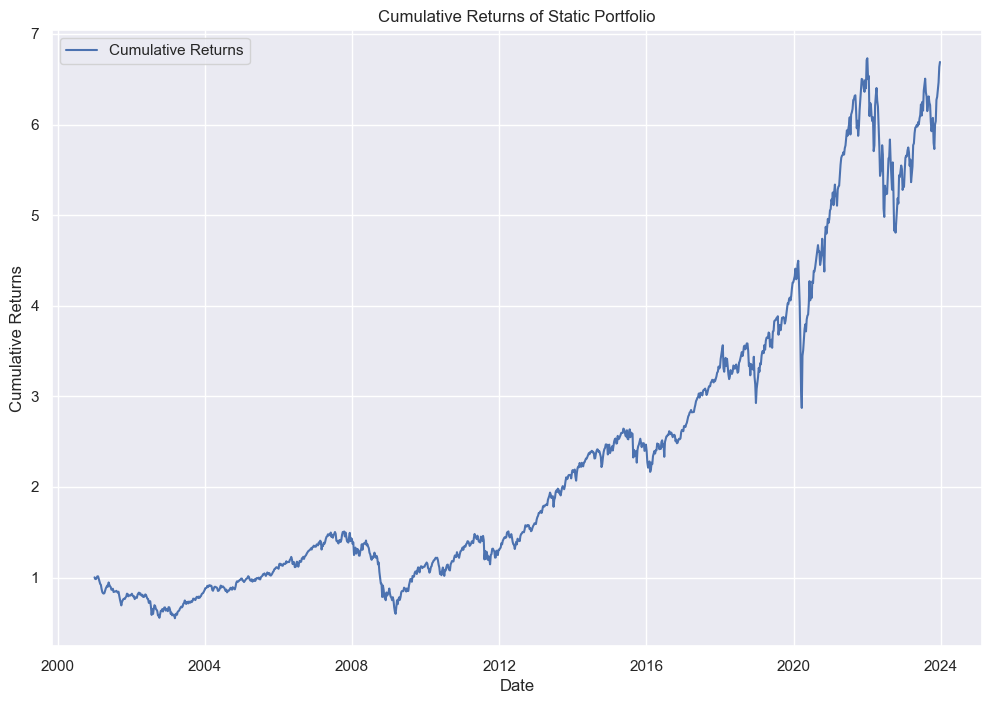

In [210]:
plt.figure(figsize=(12, 8))
plt.plot(cumulative_returns, label='Cumulative Returns')
plt.title('Cumulative Returns of Static Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


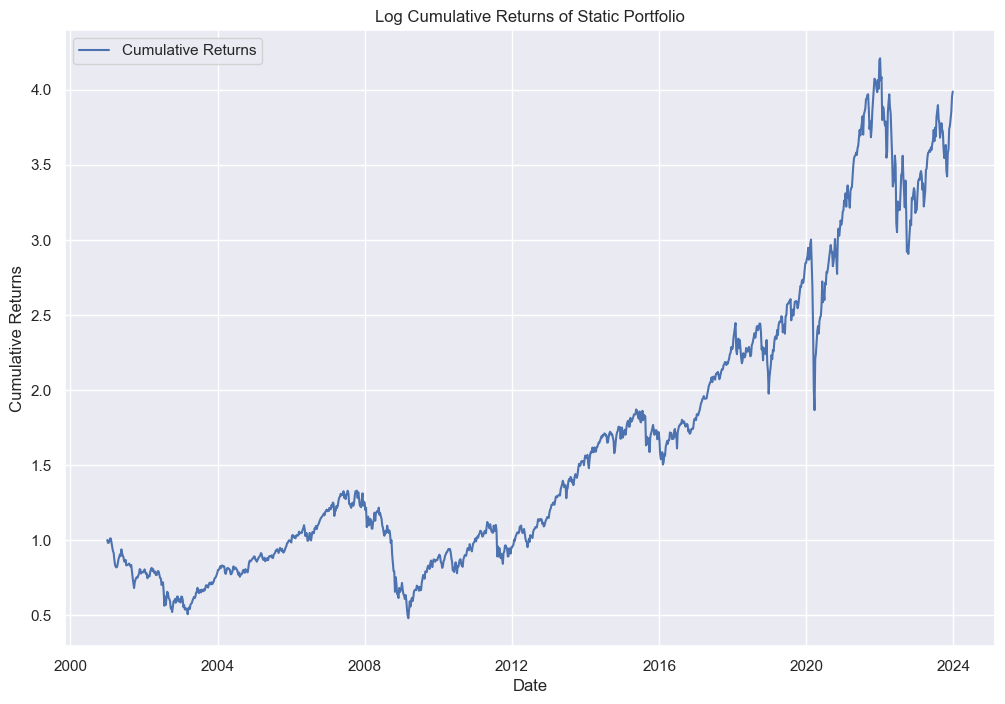

In [211]:
plt.figure(figsize=(12, 8))
plt.plot(log_cumulative_static_2, label='Cumulative Returns')
plt.title('Log Cumulative Returns of Static Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


### Static approach when lambda = 10

In [212]:
bond_returns = SMI_returns['SMI']
bond_weight = weights_static_10['Bond Weight']
bond_returns.index = pd.to_datetime(bond_returns.index)
bond_weight.index = pd.to_datetime(bond_weight.index)

alloc_bond = bond_weight*bond_returns # Ca represente l'allocation dans les bonds

stock_returns = SP500_returns['S&P 500']  
stock_weights = weights_static_10['Stock Weight']  
stock_returns.index = pd.to_datetime(stock_returns.index)
stock_weights.index = pd.to_datetime(stock_weights.index)

alloc_stock = stock_weights * stock_returns # ca represente l'allocation dans les stocks 

# Encore une fois ici je ne suis pas sur de comment aborder les rf est ce que on doit utiliser l'average ou alors
# comme je fais ici. Dans tout les cas ca ne change pas grand chose

rf_t = US_deposit['US DOLLAR S/T DEPOSIT (FT/RFV) - MIDDLE RATE']
rf_t.index = pd.to_datetime(rf_t.index)


alloc_rf = (1-bond_weight-stock_weights)*rf_t 
# Ca represente l'allocation dans le rf

portfolio_return_static10 = alloc_bond + alloc_stock + alloc_rf

cumulative_returns10 = (1+portfolio_return_static10).cumprod()

#Computed for the transaction cost
log_portfolio_return_static10 = np.log(1 + portfolio_return_static10)
log_cumulative_static_10 = (1 + log_portfolio_return_static10).cumprod()


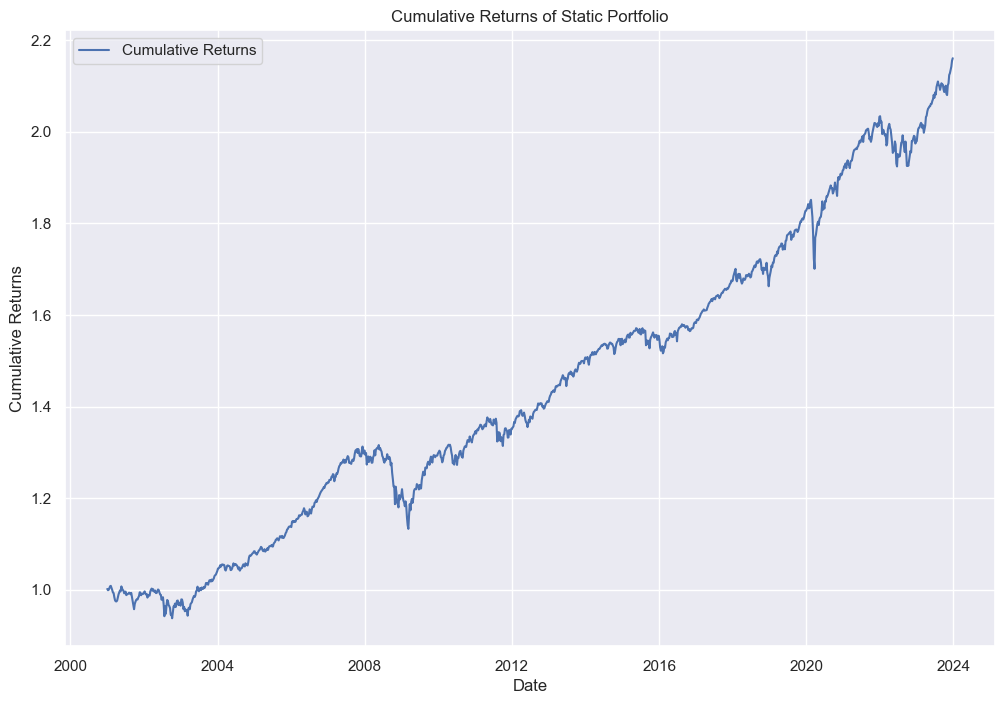

In [213]:
plt.figure(figsize=(12, 8))
plt.plot(cumulative_returns10, label='Cumulative Returns')
plt.title('Cumulative Returns of Static Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()


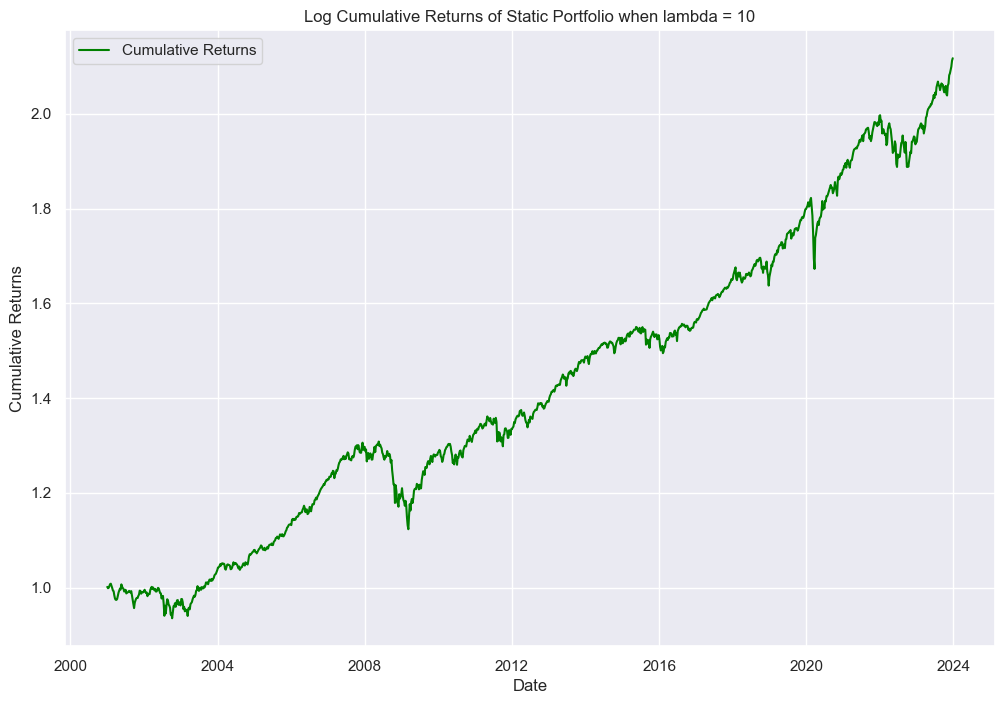

In [214]:
plt.figure(figsize=(12, 8))
plt.plot(log_cumulative_static_10, label='Cumulative Returns', color = 'green')
plt.title('Log Cumulative Returns of Static Portfolio when lambda = 10')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

In [215]:
# Le code pour la partie logarithmique sert a rien 
#Les rendements ne sont pas explosif donc aucune utilite de prendre le log
#D'ailleurs apres reflexion je ne pense pas que ce soit la bonne maniere.

### Dynnamic approach when lambda = 2 

In [216]:
bond_returns = SMI_returns['SMI'].iloc[1:]  # ici j'utilise iloc[1:] pour matcher les dates a partir de 2001-01-08
bond_weight = alpha_hats2['Weight Bond']
bond_returns.index = pd.to_datetime(bond_returns.index)
bond_weight.index = pd.to_datetime(bond_weight.index)

alloc_bond_d2 = bond_weight*bond_returns # Ca represente l'allocation dans les bonds

stock_returns = SP500_returns['S&P 500'].iloc[1:]  
stock_weights = alpha_hats2['Weight Stock']  
stock_returns.index = pd.to_datetime(stock_returns.index)
stock_weights.index = pd.to_datetime(stock_weights.index)

alloc_stock_d2 = stock_weights * stock_returns # ca represente l'allocation dans les stocks 

# Encore une fois ici je ne suis pas sur de comment aborder les rf est ce que on doit utiliser l'average ou alors
# comme je fais ici. Dans tout les cas ca ne change pas grand chose

rf_t = US_deposit['US DOLLAR S/T DEPOSIT (FT/RFV) - MIDDLE RATE']
rf_t.index = pd.to_datetime(rf_t.index)


alloc_rf_d2 = (1-bond_weight-stock_weights)*rf_t.iloc[1:] 
# Ca represente l'allocation dans le rf

portfolio_return_dyn2 = alloc_bond_d2 + alloc_stock_d2 + alloc_rf_d2

cumulative_returns_d2 = (1+portfolio_return_dyn2).cumprod()

cumulative_returns_d2

portfolio_return_dyn2 = portfolio_return_dyn2.astype(float)


In [217]:
log_returns2 = np.log(1 + portfolio_return_dyn2)

cumulative_log_returns_dyn2 = np.cumsum(log_returns2)


# Grace a ce code j'obtient des valeurs beaucoup moins explosive

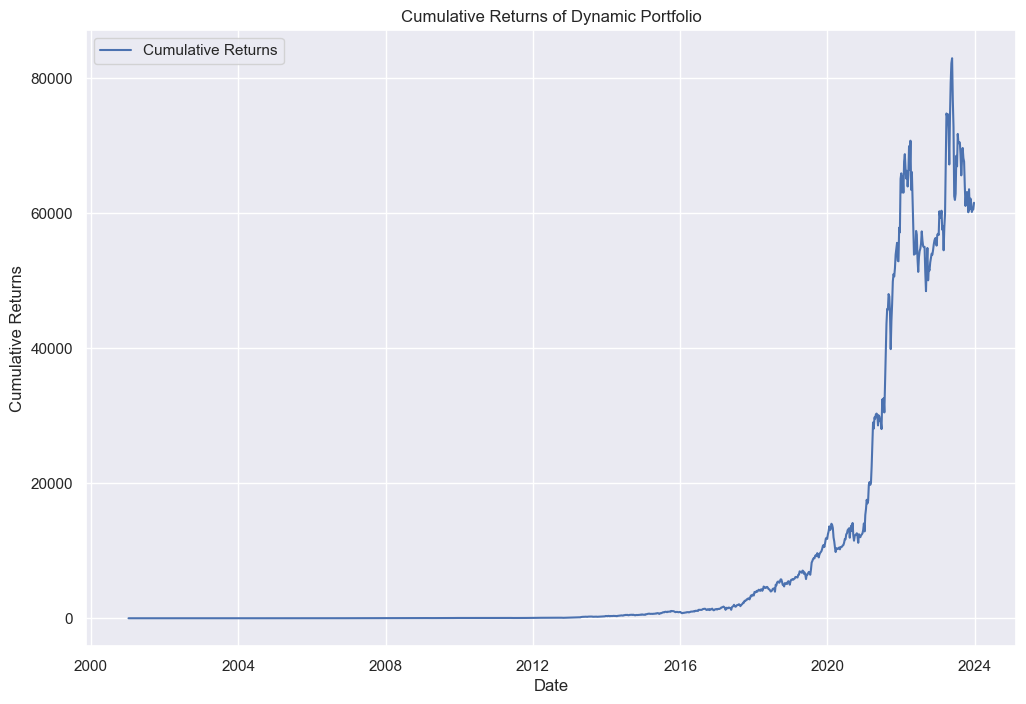

In [218]:
plt.figure(figsize=(12, 8))
plt.plot(cumulative_returns_d2, label='Cumulative Returns')
plt.title('Cumulative Returns of Dynamic Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

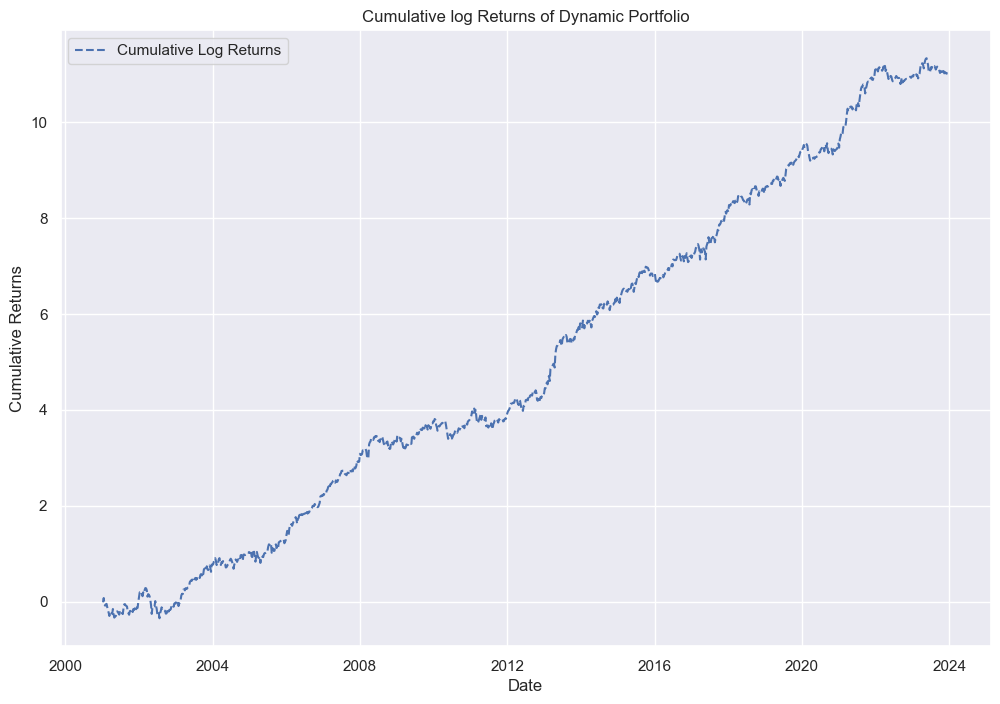

In [219]:
plt.figure(figsize=(12, 8))
plt.plot(cumulative_log_returns_dyn2, label='Cumulative Log Returns', linestyle='--')
plt.title('Cumulative log Returns of Dynamic Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

### Dynnamic approach when lambda = 10

In [220]:
bond_returns = SMI_returns['SMI'].iloc[1:]  # ici j'utilise iloc[1:] pour matcher les dates a partir de 2001-01-08
bond_weight = alpha_hats10['Weight Bond']
bond_returns.index = pd.to_datetime(bond_returns.index)
bond_weight.index = pd.to_datetime(bond_weight.index)

alloc_bond_d10 = bond_weight*bond_returns # Ca represente l'allocation dans les bonds

stock_returns = SP500_returns['S&P 500'].iloc[1:]  
stock_weights = alpha_hats10['Weight Stock']  
stock_returns.index = pd.to_datetime(stock_returns.index)
stock_weights.index = pd.to_datetime(stock_weights.index)

alloc_stock_d10 = stock_weights * stock_returns # ca represente l'allocation dans les stocks 

# Encore une fois ici je ne suis pas sur de comment aborder les rf est ce que on doit utiliser l'average ou alors
# comme je fais ici. Dans tout les cas ca ne change pas grand chose

rf_t = US_deposit['US DOLLAR S/T DEPOSIT (FT/RFV) - MIDDLE RATE']
rf_t.index = pd.to_datetime(rf_t.index)


alloc_rf_d10 = (1-bond_weight-stock_weights)*rf_t.iloc[1:] 
# Ca represente l'allocation dans le rf

portfolio_return_dyn10 = alloc_bond_d10 + alloc_stock_d10 + alloc_rf_d10

cumulative_returns_d10 = (1+portfolio_return_dyn10).cumprod()

cumulative_returns_d10


# Log to get less explosive values

portfolio_return_dyn10 = portfolio_return_dyn10.astype(float)

log_returns_d10 = np.log(1 + portfolio_return_dyn10)

cumulative_log_returns_dyn10 = np.cumsum(log_returns_d10)





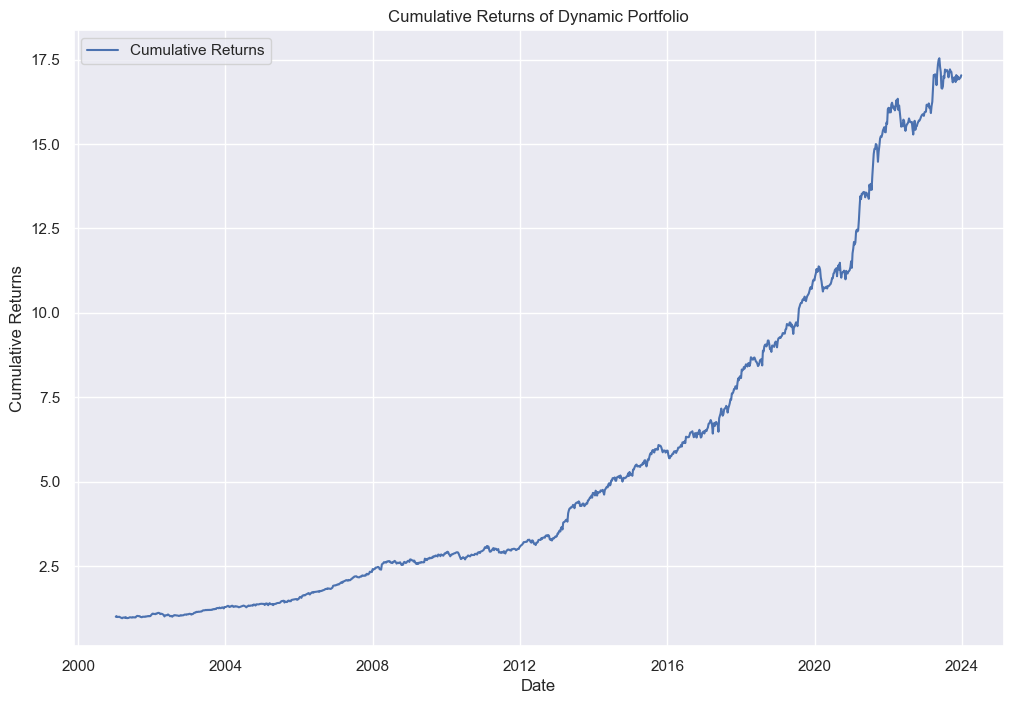

In [221]:
plt.figure(figsize=(12, 8))
plt.plot(cumulative_returns_d10, label='Cumulative Returns')
plt.title('Cumulative Returns of Dynamic Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

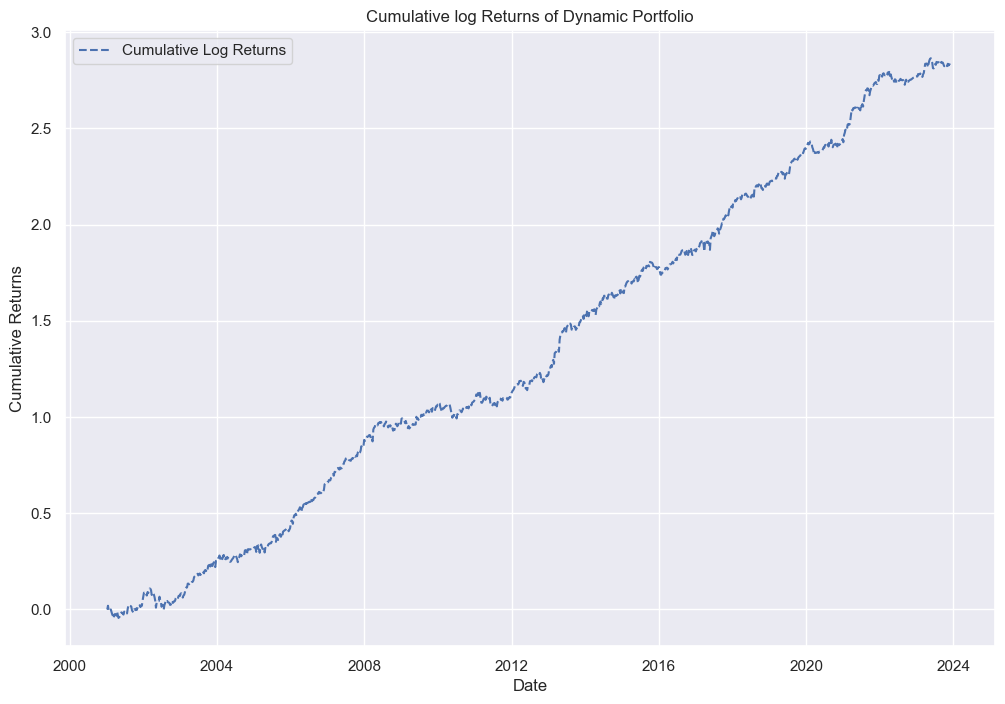

In [222]:
plt.figure(figsize=(12, 8))
plt.plot(cumulative_log_returns_dyn10, label='Cumulative Log Returns', linestyle='--')
plt.title('Cumulative log Returns of Dynamic Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

## 3.3 Transaction cost

In [223]:
stock_weight_d2

0       0.341934
1       0.076818
2       0.055356
3       0.680860
4       0.923341
          ...   
1194    0.631123
1195    0.359301
1196    0.415003
1197    0.338451
1198    0.482670
Length: 1199, dtype: float64

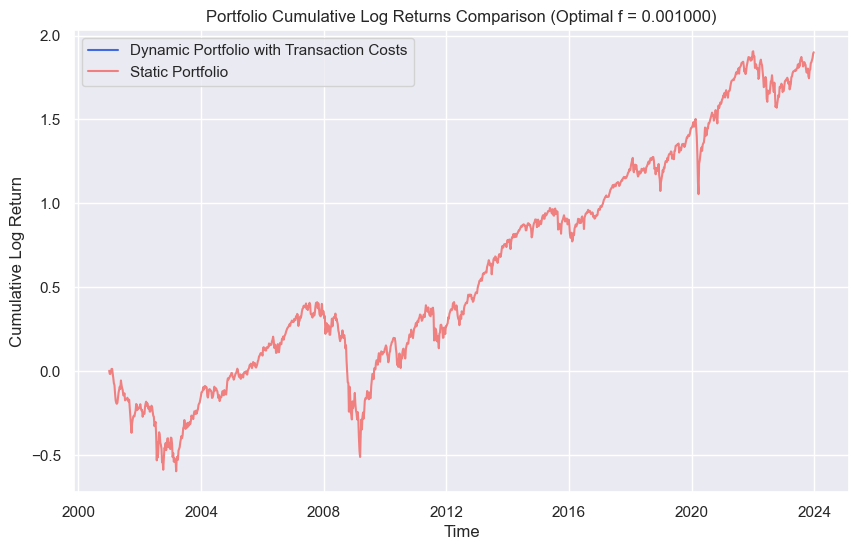

Optimal f: 0.001


In [224]:


import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


delta_stock = stock_weight_d2.diff().abs().fillna(0)
delta_bond = bond_weight_d2.diff().abs().fillna(0)

def cumulative_return_difference(f):
    TC = (delta_stock + delta_bond) * f
    PR_tc = portfolio_return_dyn2 - TC
    cumulative_dynamic_with_tc = np.log(1 + PR_tc).cumsum()
    cumulative_static = np.log(1 + portfolio_return_static2).cumsum()
    return np.sum((cumulative_dynamic_with_tc - cumulative_static)**2)

f_initial = 0.001

result = minimize(cumulative_return_difference, f_initial, method='Nelder-Mead')
optimal_f = result.x[0]

TC_optimal = (delta_stock + delta_bond) * optimal_f
PR_tc_optimal = portfolio_return_dyn2 - TC_optimal
cumulative_dynamic_with_tc_optimal = np.log(1 + PR_tc_optimal).cumsum()
cumulative_static = np.log(1 + portfolio_return_static2).cumsum()

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(cumulative_dynamic_with_tc_optimal, label="Dynamic Portfolio with Transaction Costs", color='royalblue')
ax.plot(cumulative_static, label="Static Portfolio", color='lightcoral')
ax.set_xlabel("Time")
ax.set_ylabel("Cumulative Log Return")
ax.legend()
ax.set_title(f"Portfolio Cumulative Log Returns Comparison (Optimal f = {optimal_f:.6f})")
plt.show()

print(f"Optimal f: {optimal_f}")


# 4 Compute the VAR of the portfolio

In [114]:
#good overview of VAR
#https://medium.com/@matt_84072/historical-simulation-value-at-risk-explained-with-python-code-a904d848d146

In [115]:
from scipy.stats import norm

## Importation daily data

In [121]:
daily_SP500 = pd.read_excel('/Users/enzorua/Desktop/EMF/Project 2/SP500 daily prices.xlsx')
daily_SMI = pd.read_excel('/Users/enzorua/Desktop/EMF/Project 2/SMI daily prices.xlsx')
daily_rf = pd.read_excel('/Users/enzorua/Desktop/EMF/Project 2/Rf daily.xlsx')

In [122]:
daily_SP500['Date'] = pd.to_datetime(daily_SP500['Date'])
daily_SP500.set_index('Date',inplace = True)

daily_SMI['Date'] = pd.to_datetime(daily_SMI['Date'])
daily_SMI.set_index('Date',inplace = True)

daily_rf['Date'] = pd.to_datetime(daily_rf['Date'])
daily_rf.set_index('Date',inplace = True)

daily_SP500_returns = daily_SP500.pct_change()
daily_SP500_returns = daily_SP500_returns.apply(lambda x : x.fillna(x.mean()),axis = 0)


daily_SMI_returns = daily_SMI.pct_change()
daily_SMI_returns = daily_SMI_returns.apply(lambda x : x.fillna(x.mean()),axis = 0)

daily_rf = daily_rf/36500 # to get in % and daily

#Question about rf, before we divide by 

## Construction of the different portfolios

In [123]:
#Portfolio static with lambda = 2

# Extraction des poids 
stock_weight = 0.770011  
bond_weight = 0.425597  
bond_returns_daily = daily_SMI_returns['SMI']
alloc_bond_daily = bond_weight*bond_returns_daily # Ca represente l'allocation dans les bonds

stock_returns_daily = daily_SP500_returns['SP500']
alloc_stock_daily = stock_weight * stock_returns_daily

rf_t = daily_rf['RF']
alloc_rf = (1-bond_weight-stock_weight)*rf_t

daily_pr = alloc_bond_daily + alloc_stock_daily + alloc_rf
static_dpr_loss2 = -(daily_pr)
#static_dpr_loss2


In [124]:
#Portfolio static with lambda = 10


stock_weight_s10 = 0.154002	
bond_weight_s10 = 0.085119

  
alloc_bond_daily_s10 = bond_weight_s10*bond_returns_daily 

alloc_stock_daily_s10 = stock_weight_s10 * stock_returns_daily

alloc_rf_s10 = (1-bond_weight-stock_weight)*rf_t



daily_pr_s10 = alloc_bond_daily_s10 + alloc_stock_daily_s10 + alloc_rf_s10


static_dpr_loss10 = -(daily_pr_s10)


#static_dpr_loss10

In [125]:
start_date = pd.Timestamp('2001-01-01')
end_date = alpha_hats2.index.max()
new_index = pd.date_range(start=start_date, end=end_date, freq='B')  

alpha_hats2_d = alpha_hats2.reindex(new_index)
alpha_hats2_d.fillna(method='ffill', inplace=True)  
alpha_hats2_d.fillna(method='bfill', inplace=True)  

# Afficher le nouveau dataframe
#alpha_hats2_d

In [126]:
start_date = pd.Timestamp('2001-01-01')
end_date = alpha_hats2.index.max()
new_index = pd.date_range(start=start_date, end=end_date, freq='B')  

alpha_hats10_d = alpha_hats10.reindex(new_index)
alpha_hats10_d.fillna(method='ffill', inplace=True)  
alpha_hats10_d.fillna(method='bfill', inplace=True)  

# Afficher le nouveau dataframe
#alpha_hats10_d

In [127]:
#Portfolio dynamic with lambda = 2

alloc_bond_daily_d2 = alpha_hats2_d['Weight Bond']*bond_returns_daily
alloc_stock_daily_d2 = alpha_hats2_d['Weight Stock']*stock_returns_daily
alloc_rf_d2 = (1-alpha_hats2_d['Weight Stock']-alpha_hats2_d['Weight Bond'])*rf_t

daily_pr_d2 = alloc_bond_daily_d2 + alloc_stock_daily_d2 + alloc_rf_d2
dynnamic_dpr_loss2 = -(daily_pr_d2)


In [128]:
#Portfolio dynamic with lambda = 10
alloc_bond_daily_d10 = alpha_hats10_d['Weight Bond']*bond_returns_daily
alloc_stock_daily_d10 = alpha_hats10_d['Weight Stock']*stock_returns_daily
alloc_rf_d10 = (1-alpha_hats10_d['Weight Bond']-alpha_hats10_d['Weight Stock'])*rf_t

daily_pr_d10 = alloc_bond_daily_d10 + alloc_stock_daily_d10 + alloc_rf_d10
dynnamic_dpr_loss10 = -(daily_pr_d10)


## 4.1) Unconditional VAR

In [129]:
#Pour portfolio static 2

E_pl_s2 = static_dpr_loss2.mean()
V_pl_s2 = static_dpr_loss2.var()
# Unconditional quantile
uncond_quantile_static_2 = np.quantile(static_dpr_loss2, 0.99)
z_score_99 = stats.norm.ppf(0.99)
sd = V_pl_s2 ** 0.5
# Calculate the VaR at the 99% confidence level
VaR_99_s2 = E_pl_s2 + z_score_99 * sd

# Print the result
print("Unconditional quantile at 99% ", uncond_quantile_static_2)
print("Value at Risk (VaR) at 99% Confidence Level:", VaR_99_s2)


Unconditional quantile at 99%  0.03743025573883875
Value at Risk (VaR) at 99% Confidence Level: 0.028409261632750767


In [130]:
#Pour portfolio static 10
E_pl_s10 = static_dpr_loss10.mean()
V_pl_s10 = static_dpr_loss10.var()
# Unconditional quantile
uncond_quantile_static_10 = np.quantile(static_dpr_loss10, 0.99)
z_score_99 = stats.norm.ppf(0.99)
sd = V_pl_s10 ** 0.5
# Calculate the VaR at the 99% confidence level
VaR_99_s10 = E_pl_s10 + z_score_99 * sd

# Print the result
print("Unconditional quantile at 99% ", uncond_quantile_static_10)
print("Value at Risk (VaR) at 99% Confidence Level:", VaR_99_s10)




Unconditional quantile at 99%  0.007486907177567019
Value at Risk (VaR) at 99% Confidence Level: 0.005689252939310587


In [131]:
#Pour portfolio dynnamic 2
E_pl_d2 = dynnamic_dpr_loss2.mean()
V_pl_d2 = dynnamic_dpr_loss2.var()
# Unconditional quantile
uncond_quantile_dynamic_2 = np.quantile(dynnamic_dpr_loss2, 0.99)
z_score_99 = stats.norm.ppf(0.99)
sd = V_pl_d2 ** 0.5
# Calculate the VaR at the 99% confidence level
VaR_99_d2 = E_pl_d2 + z_score_99 * sd

# Print the result
print("Unconditional quantile at 99% ", uncond_quantile_dynamic_2)
print("Value at Risk (VaR) at 99% Confidence Level:", VaR_99_d2)


Unconditional quantile at 99%  0.11940690106169183
Value at Risk (VaR) at 99% Confidence Level: 0.09041139104185132


In [132]:
#Pour portfolio dynnamic 10
E_pl_d10 = dynnamic_dpr_loss10.mean()
V_pl_d10 = dynnamic_dpr_loss10.var()
# Unconditional quantile
uncond_quantile_dynamic_10 = np.quantile(dynnamic_dpr_loss10, 0.99)
z_score_99 = stats.norm.ppf(0.99)
sd = V_pl_d10 ** 0.5
# Calculate the VaR at the 99% confidence level
VaR_99_d10 = E_pl_d10 + z_score_99 * sd

# Print the result
print("Unconditional quantile at 99% ", uncond_quantile_dynamic_10)
print("Value at Risk (VaR) at 99% Confidence Level:", VaR_99_d10)
print(E_pl_d10)


Unconditional quantile at 99%  0.02387012959512013
Value at Risk (VaR) at 99% Confidence Level: 0.01804513039236609
-0.0002831402881472748


In [133]:
import pandas as pd

# Supposons que tu aies quatre portfolios avec des valeurs calculées pour la VaR et les quantiles
data = {
    'Portfolio': ['Portfolio static 2', 'Portfolio static 10', 'Portfolio dynnamic 2', 'Portfolio dynnamcic 10'],
    'Unconditional mean':[E_pl_s2, E_pl_s10, E_pl_d2,E_pl_d10],
    'Uncondtional Var':[V_pl_s2,V_pl_s10,V_pl_d2,V_pl_d10],
    'Unconditional VaR': [VaR_99_s2, VaR_99_s10, VaR_99_d2, VaR_99_d10],  # Remplace var1, var2, etc. par les valeurs de VaR calculées
    'Unconditional Quantile': [uncond_quantile_static_2, uncond_quantile_static_10, uncond_quantile_dynamic_2, uncond_quantile_dynamic_10]  # Remplace quantile1, quantile2, etc. par les valeurs de quantile calculées
}

# Créer le dataframe
df = pd.DataFrame(data)

# Afficher le dataframe
df

,Portfolio,Unconditional mean,Uncondtional Var,Unconditional VaR,Unconditional Quantile
0,Portfolio static 2,-0.000410,0.000153,0.028409,0.037430
1,Portfolio static 10,-0.000075,0.000006,0.005689,0.007487
2,Portfolio dynnamic 2,-0.001234,0.001552,0.090411,0.119407
3,Portfolio dynnamcic 10,-0.000283,0.000062,0.018045,0.023870


## 4.2) AR(1)-GARCH(1,1) model

In [134]:
#For portfolio static 2

#AR(1) model
ar1_model = AutoReg(static_dpr_loss2,lags=1).fit()
residuals = ar1_model.resid
rho = ar1_model.params['y.L1']
const = ar1_model.params['const']
#GARCH(1,1) model
garch_model = arch_model(residuals,vol ='Garch',p=1,q=1).fit(disp='off')

omega = garch_model.params['omega']
alpha = garch_model.params['alpha[1]']
beta = garch_model.params['beta[1]']

# Etablir une boucle afin de calculer u et sigma pour chaque date en fonction des premieres donnes

n = len(static_dpr_loss2)
sigma2_p_t1 = np.zeros(n)
mu_p_t1 = np.zeros(n)

#Initialisation

sigma2_p_t1[0] = residuals.var()  

#boucle temporelle

for t in range(1, n):
    sigma2_p_t1[t] = omega + alpha * residuals[t-1]**2 + beta * sigma2_p_t1[t-1]
    mu_p_t1[t] = const + rho * static_dpr_loss2[t-1]

z_score_99 = stats.norm.ppf(0.99)

conditional_VaR_99 = mu_p_t1 + z_score_99 * np.sqrt(sigma2_p_t1)

#Computation of conditional quantile

conditional_quantile_99 = np.zeros(n)
for t in range(n):
    conditional_quantile_99[t] = np.quantile(np.random.normal(mu_p_t1[t], np.sqrt(sigma2_p_t1[t]), 1000), 0.99)



# Combiner les résultats dans un DataFrame pour une meilleure visualisation
results_df = pd.DataFrame({
    'Date': static_dpr_loss2.index,
    'Forecast_Mean': mu_p_t1,
    'Conditional_Var': sigma2_p_t1,
    'Conditional_VaR_99': conditional_VaR_99,
    'Conditional_Quantile_99' : conditional_quantile_99
})

results_df

/Users/enzorua/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,Date,Forecast_Mean,Conditional_Var,Conditional_VaR_99,Conditional_Quantile_99
0,2001-01-01,0.000000,0.000153,0.028821,0.026203
1,2001-01-02,-0.000410,0.000173,0.030183,0.031486
2,2001-01-03,-0.000299,0.000299,0.039897,0.040687
3,2001-01-04,-0.000636,0.000274,0.037874,0.038474
4,2001-01-05,-0.000357,0.000316,0.041020,0.039476
...,...,...,...,...,...
5991,2023-12-19,-0.000417,0.000055,0.016888,0.017115
5992,2023-12-20,-0.000457,0.000067,0.018632,0.017723
5993,2023-12-21,-0.000336,0.000071,0.019249,0.019517
5994,2023-12-22,-0.000465,0.000066,0.018429,0.018407


In [135]:
#For portfolio static 10

#AR(1) model
ar1_model = AutoReg(static_dpr_loss10,lags=1).fit()
residuals = ar1_model.resid
rho = ar1_model.params['y.L1']
const = ar1_model.params['const']
#GARCH(1,1) model
garch_model_s10 = arch_model(residuals,vol ='Garch',p=1,q=1).fit(disp='off')

omega = garch_model.params['omega']
alpha = garch_model.params['alpha[1]']
beta = garch_model.params['beta[1]']

# Etablir une boucle afin de calculer u et sigma pour chaque date en fonction des premieres donnes

n = len(static_dpr_loss10)
sigma2_p_t1 = np.zeros(n)
mu_p_t1 = np.zeros(n)

#Initialisation

sigma2_p_t1[0] = residuals.var()  

#boucle temporelle

for t in range(1, n):
    sigma2_p_t1[t] = omega + alpha * residuals[t-1]**2 + beta * sigma2_p_t1[t-1]
    mu_p_t1[t] = const + rho * static_dpr_loss10[t-1]

z_score_99 = stats.norm.ppf(0.99)

conditional_VaR_99 = mu_p_t1 + z_score_99 * np.sqrt(sigma2_p_t1)

#Computation of conditional quantile

conditional_quantile_99 = np.zeros(n)
for t in range(n):
    conditional_quantile_99[t] = np.quantile(np.random.normal(mu_p_t1[t], np.sqrt(sigma2_p_t1[t]), 1000), 0.99)



# Combiner les résultats dans un DataFrame pour une meilleure visualisation
results_df_s10 = pd.DataFrame({
    'Date': static_dpr_loss10.index,
    'Forecast_Mean': mu_p_t1,
    'Conditional_Var': sigma2_p_t1,
    'Conditional_VaR_99': conditional_VaR_99,
    'Conditional_Quantile_99' : conditional_quantile_99
})

results_df_s10

/Users/enzorua/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


,Date,Forecast_Mean,Conditional_Var,Conditional_VaR_99,Conditional_Quantile_99
0,2001-01-01,0.000000,0.000006,0.005765,0.005398
1,2001-01-02,-0.000075,0.000010,0.007250,0.006949
2,2001-01-03,-0.000052,0.000018,0.009687,0.009668
3,2001-01-04,-0.000121,0.000019,0.009982,0.009560
4,2001-01-05,-0.000064,0.000023,0.010996,0.010823
...,...,...,...,...,...
5991,2023-12-19,-0.000076,0.000027,0.012015,0.012024
5992,2023-12-20,-0.000084,0.000028,0.012116,0.012283
5993,2023-12-21,-0.000060,0.000028,0.012171,0.011522
5994,2023-12-22,-0.000086,0.000027,0.012101,0.012710


In [136]:
#For portfolio dynnamic 2

#AR(1) model
ar1_model = AutoReg(dynnamic_dpr_loss2,lags=1).fit()
residuals = ar1_model.resid
rho = ar1_model.params['y.L1']
const = ar1_model.params['const']
#GARCH(1,1) model
garch_model_s10 = arch_model(residuals,vol ='Garch',p=1,q=1).fit(disp='off')

omega = garch_model.params['omega']
alpha = garch_model.params['alpha[1]']
beta = garch_model.params['beta[1]']

# Etablir une boucle afin de calculer u et sigma pour chaque date en fonction des premieres donnes

n = len(static_dpr_loss10)
sigma2_p_t1 = np.zeros(n)
mu_p_t1 = np.zeros(n)

#Initialisation

sigma2_p_t1[0] = residuals.var()  

#boucle temporelle

for t in range(1, n):
    sigma2_p_t1[t] = omega + alpha * residuals[t-1]**2 + beta * sigma2_p_t1[t-1]
    mu_p_t1[t] = const + rho * dynnamic_dpr_loss2[t-1]

z_score_99 = stats.norm.ppf(0.99)

conditional_VaR_99 = mu_p_t1 + z_score_99 * np.sqrt(sigma2_p_t1)

#Computation of conditional quantile

conditional_quantile_99 = np.zeros(n)
for t in range(n):
    conditional_quantile_99[t] = np.quantile(np.random.normal(mu_p_t1[t], np.sqrt(sigma2_p_t1[t]), 1000), 0.99)



# Combiner les résultats dans un DataFrame pour une meilleure visualisation
results_df_d2 = pd.DataFrame({
    'Date': dynnamic_dpr_loss2.index,
    'Forecast_Mean': mu_p_t1,
    'Conditional_Var': sigma2_p_t1,
    'Conditional_VaR_99': conditional_VaR_99,
    'Conditional_Quantile_99' : conditional_quantile_99
})

results_df_d2

,Date,Forecast_Mean,Conditional_Var,Conditional_VaR_99,Conditional_Quantile_99
0,2001-01-01,0.000000,0.001536,0.091178,0.090580
1,2001-01-02,-0.001330,0.001381,0.085133,0.079753
2,2001-01-03,-0.002877,0.001281,0.080386,0.075878
3,2001-01-04,0.001470,0.001132,0.079750,0.082753
4,2001-01-05,-0.001951,0.001030,0.072707,0.070709
...,...,...,...,...,...
5991,2023-12-19,-0.001521,0.000204,0.031689,0.031037
5992,2023-12-20,-0.001282,0.000183,0.030153,0.026870
5993,2023-12-21,-0.001105,0.000164,0.028707,0.026353
5994,2023-12-22,-0.001461,0.000148,0.026812,0.026193


In [137]:
#For portfolio dynnamic 10

#AR(1) model
ar1_model = AutoReg(dynnamic_dpr_loss10,lags=1).fit()
residuals = ar1_model.resid
rho = ar1_model.params['y.L1']
const = ar1_model.params['const']
#GARCH(1,1) model
garch_model_s10 = arch_model(residuals,vol ='Garch',p=1,q=1).fit(disp='off')

omega = garch_model.params['omega']
alpha = garch_model.params['alpha[1]']
beta = garch_model.params['beta[1]']

# Etablir une boucle afin de calculer u et sigma pour chaque date en fonction des premieres donnes

n = len(static_dpr_loss10)
sigma2_p_t1 = np.zeros(n)
mu_p_t1 = np.zeros(n)

#Initialisation

sigma2_p_t1[0] = residuals.var()  

#boucle temporelle

for t in range(1, n):
    sigma2_p_t1[t] = omega + alpha * residuals[t-1]**2 + beta * sigma2_p_t1[t-1]
    mu_p_t1[t] = const + rho * dynnamic_dpr_loss10[t-1]

z_score_99 = stats.norm.ppf(0.99)

conditional_VaR_99 = mu_p_t1 + z_score_99 * np.sqrt(sigma2_p_t1)

#Computation of conditional quantile

conditional_quantile_99 = np.zeros(n)
for t in range(n):
    conditional_quantile_99[t] = np.quantile(np.random.normal(mu_p_t1[t], np.sqrt(sigma2_p_t1[t]), 1000), 0.99)



# Combiner les résultats dans un DataFrame pour une meilleure visualisation
results_df_d10 = pd.DataFrame({
    'Date': dynnamic_dpr_loss10.index,
    'Forecast_Mean': mu_p_t1,
    'Conditional_Var': sigma2_p_t1,
    'Conditional_VaR_99': conditional_VaR_99,
    'Conditional_Quantile_99' : conditional_quantile_99
})

results_df_d10

,Date,Forecast_Mean,Conditional_Var,Conditional_VaR_99,Conditional_Quantile_99
0,2001-01-01,0.000000,0.000061,0.018235,0.018219
1,2001-01-02,-0.000291,0.000058,0.017449,0.018048
2,2001-01-03,-0.000601,0.000057,0.016945,0.015945
3,2001-01-04,0.000269,0.000053,0.017240,0.017404
4,2001-01-05,-0.000417,0.000051,0.016209,0.014887
...,...,...,...,...,...
5991,2023-12-19,-0.000332,0.000033,0.013020,0.013208
5992,2023-12-20,-0.000285,0.000032,0.012897,0.013052
5993,2023-12-21,-0.000249,0.000031,0.012780,0.012698
5994,2023-12-22,-0.000320,0.000031,0.012571,0.012462


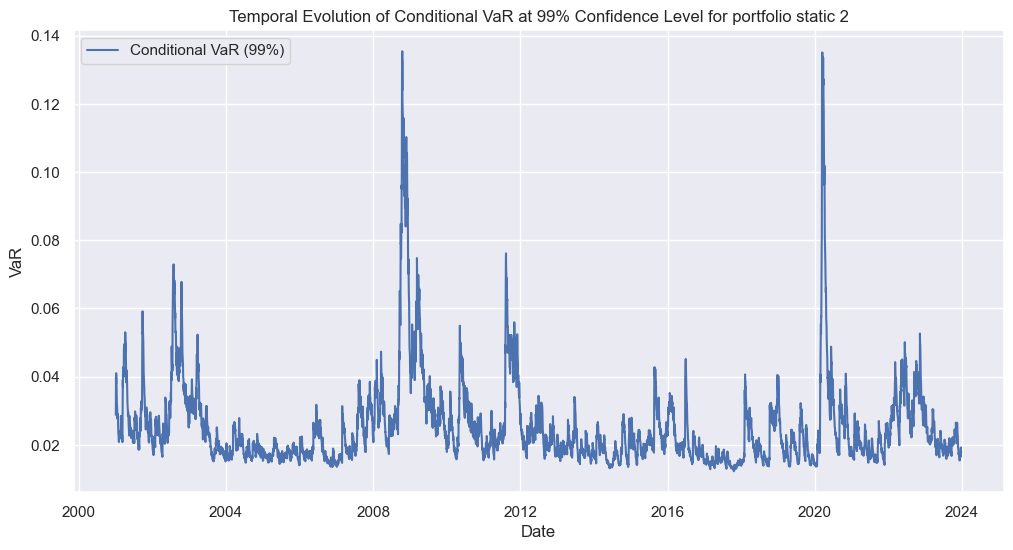

In [138]:
# Visualiser l'évolution temporelle de la VaR conditionnelle
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df['Conditional_VaR_99'], label='Conditional VaR (99%)')
plt.xlabel('Date')
plt.ylabel('VaR')
plt.title('Temporal Evolution of Conditional VaR at 99% Confidence Level for portfolio static 2')
plt.legend()
plt.show()

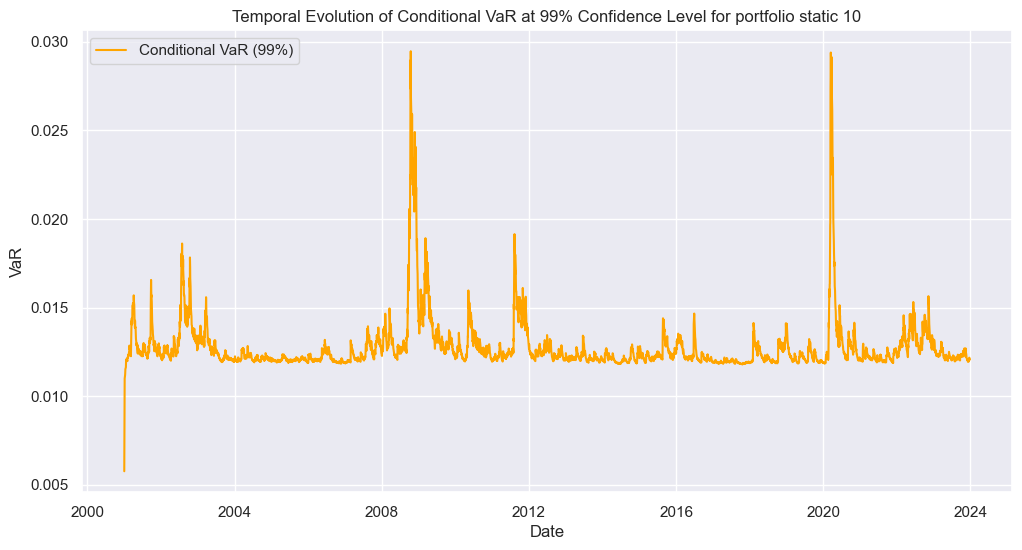

In [139]:
# Visualiser l'évolution temporelle de la VaR conditionnelle
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df_s10['Conditional_VaR_99'], label='Conditional VaR (99%)',color ='orange')
plt.xlabel('Date')
plt.ylabel('VaR')
plt.title('Temporal Evolution of Conditional VaR at 99% Confidence Level for portfolio static 10')
plt.legend()
plt.show()

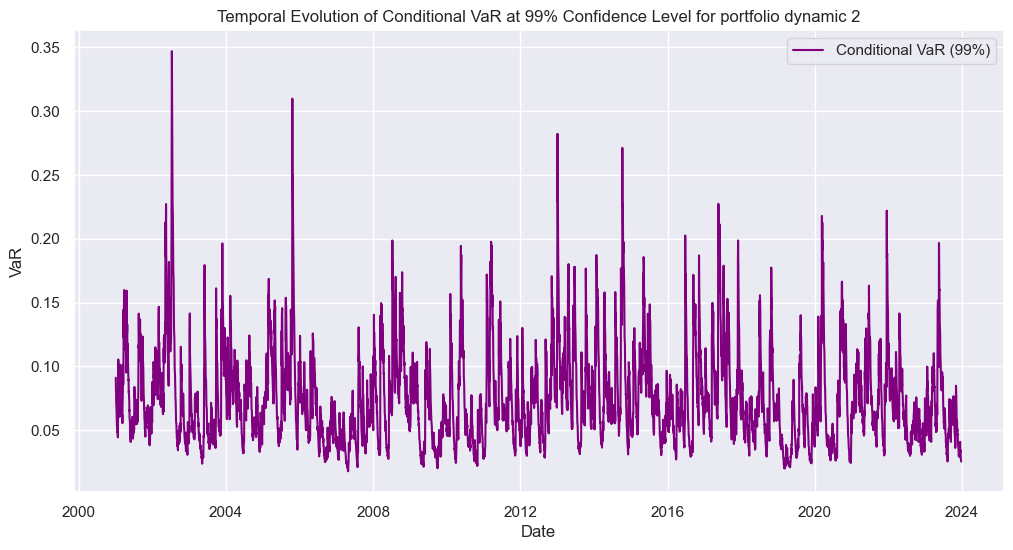

In [140]:
# Visualiser l'évolution temporelle de la VaR conditionnelle
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df_d2['Conditional_VaR_99'], label='Conditional VaR (99%)',color = 'purple')
plt.xlabel('Date')
plt.ylabel('VaR')
plt.title('Temporal Evolution of Conditional VaR at 99% Confidence Level for portfolio dynamic 2')
plt.legend()
plt.show()

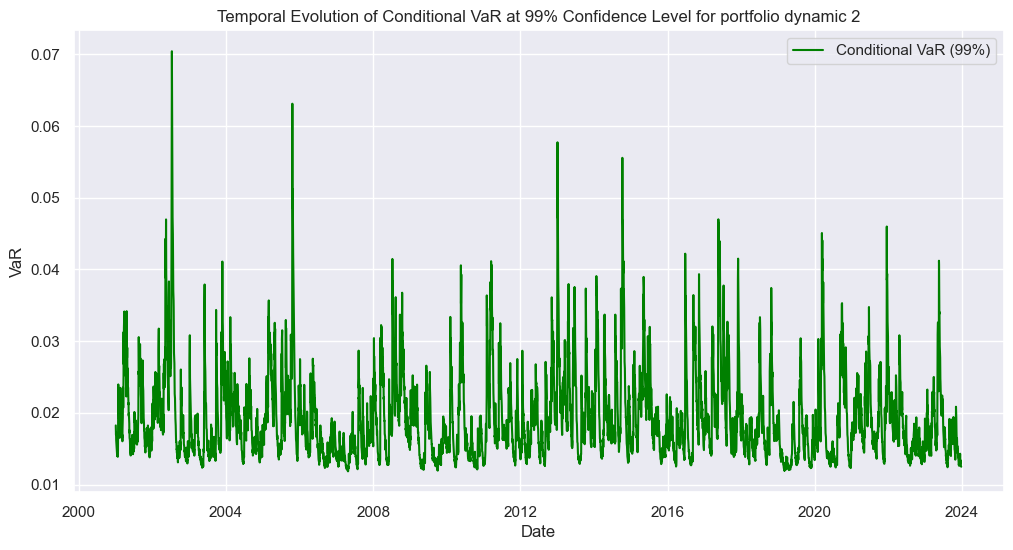

In [141]:
# Visualiser l'évolution temporelle de la VaR conditionnelle
plt.figure(figsize=(12, 6))
plt.plot(results_df['Date'], results_df_d10['Conditional_VaR_99'], label='Conditional VaR (99%)',color = 'green')
plt.xlabel('Date')
plt.ylabel('VaR')
plt.title('Temporal Evolution of Conditional VaR at 99% Confidence Level for portfolio dynamic 2')
plt.legend()
plt.show()

## 4.3 GEV

In [142]:
#For portfolio static 2
z_hat = (static_dpr_loss2 - mu_p_t1) / np.sqrt(sigma2_p_t1)
days_per_quarter = 60
mt = [z_hat[i:i + days_per_quarter].max() for i in range(0, len(z_hat), days_per_quarter)]


# Ajuster la distribution GEV aux maxima trimestriels
params = gev.fit(mt)

# Extraire les paramètres estimés
xi, loc, scale = params
print(f"Paramètres de la distribution GEV: ξ = {xi}, ω = {loc}, ψ = {scale}")


Paramètres de la distribution GEV: ξ = -0.19107203035995984, ω = 2.4706227455326175, ψ = 1.15909274794836


In [143]:
#For portfolio static 10
z_hat = (static_dpr_loss10 - mu_p_t1) / np.sqrt(sigma2_p_t1)
days_per_quarter = 60
mt = [z_hat[i:i + days_per_quarter].max() for i in range(0, len(z_hat), days_per_quarter)]


# Ajuster la distribution GEV aux maxima trimestriels
params = gev.fit(mt)

# Extraire les paramètres estimés
xi, loc, scale = params
print(f"Paramètres de la distribution GEV: ξ = {xi}, ω = {loc}, ψ = {scale}")


Paramètres de la distribution GEV: ξ = -0.17553319533157702, ω = 0.5564557196781599, ψ = 0.23120318109652044


In [144]:
#For portfolio dynnamic 2
z_hat = (dynnamic_dpr_loss2 - mu_p_t1) / np.sqrt(sigma2_p_t1)
days_per_quarter = 60
mt = [z_hat[i:i + days_per_quarter].max() for i in range(0, len(z_hat), days_per_quarter)]


# Ajuster la distribution GEV aux maxima trimestriels
params = gev.fit(mt)

# Extraire les paramètres estimés
xi, loc, scale = params
print(f"Paramètres de la distribution GEV: ξ = {xi}, ω = {loc}, ψ = {scale}")


Paramètres de la distribution GEV: ξ = 0.3930964171973097, ω = 9.217877962160582, ψ = 2.26750837832848


In [145]:
#For portfolio dynnamic 2
z_hat = (dynnamic_dpr_loss10 - mu_p_t1) / np.sqrt(sigma2_p_t1)
days_per_quarter = 60
mt = [z_hat[i:i + days_per_quarter].max() for i in range(0, len(z_hat), days_per_quarter)]


# Ajuster la distribution GEV aux maxima trimestriels
params = gev.fit(mt)

# Extraire les paramètres estimés
xi, loc, scale = params
print(f"Paramètres de la distribution GEV: ξ = {xi}, ω = {loc}, ψ = {scale}")

Paramètres de la distribution GEV: ξ = 0.39464229112065796, ω = 1.8538596292993819, ψ = 0.44658533811471185


## 4.4 quantile mt et residus

In [146]:
def gev_quantile(p, shape, loc, scale):
    if shape == 0:
        return loc - scale * np.log(-np.log(p))
    else:
        return loc + scale / shape * ((-np.log(p)) ** (-shape) - 1)
    
def standardized_residuals_quantile(N, theta_star, mu_hat, psi_hat, xi_hat):
    if xi_hat == 0:
        return mu_hat + psi_hat * np.log(N * np.log(1 / theta_star))
    else:
        return mu_hat + (psi_hat / xi_hat) * ((-N * np.log(theta_star)) ** (-xi_hat) - 1)





In [154]:
#For portfolio dynnamic 2
z_hat = (dynnamic_dpr_loss10 - mu_p_t1) / np.sqrt(sigma2_p_t1)
days_per_quarter = 60
mt = [z_hat[i:i + days_per_quarter].max() for i in range(0, len(z_hat), days_per_quarter)]


# Ajuster la distribution GEV aux maxima trimestriels
params = gev.fit(mt)

# Extraire les paramètres estimés
xi, loc, scale = params
print(f"Paramètres de la distribution GEV: ξ = {xi}, ω = {loc}, ψ = {scale}")

Paramètres de la distribution GEV: ξ = 0.39464229112065796, ω = 1.8538596292993819, ψ = 0.44658533811471185


In [157]:
N = 60  # Number of days
theta_star = 0.99  # For 99% quantile
mu_hat = 1.8538596292993819  # Estimated location parameter (ω)
psi_hat = 0.44658533811471185  # Estimated scale parameter (ψ)
xi_hat = 0.39464229112065796  # Estimated shape parameter (ξ)


quantile = standardized_residuals_quantile(N, theta_star, mu_hat, psi_hat, xi_hat)
print(f"The 99% quantile of the standardized residuals is {quantile}")


The 99% quantile of the standardized residuals is 2.1038672489323846


In [151]:
N = 100000
theta_star = 0,99

quantile_z_bar = standardized_residuals_quantile(N,theta_star,1.8538596292993819,0.44658533811471185,0.39464229112065796)
quantile_z_bar


array([0.72223905,        nan])

In [149]:
#For portfolio static 2
q99_mt_s2 = gev_quantile(0.99, 1.8538596292993819,2.4706227455326175,1.15909274794836)

q99_zt_s2 = gev_quantile(0.99, -0.19107203035995984,0,1)
q99_zt_s2

3.060549612850195

In [98]:
#For portfolio static 10
q99_mt_s10 = gev_quantile(0.99, -0.17553319533157702,0.5564557196781599,0.23120318109652044)

q99_zt_s10 = gev_quantile(0.99, -0.17553319533157702,0,1)
q99_zt_s10


3.156206339794704

In [94]:
#For portfolio dynnamic 2
q99_mt_d2 = gev_quantile(0.99, 0.3930964171973097,9.217877962160582,2.26750837832848)
q99_zt_d2 = gev_quantile(0.99, 0.3930964171973097,0,1)




In [96]:
#Portfolio dynnamic 10
q99_mt_d10 = gev_quantile(0.99, 0.39464229112065796,1.8538596292993819,0.44658533811471185)
q99_zt_d10 = gev_quantile(0.99, 0.39464229112065796,0,1)


In [102]:
q99_zt_s2

3.060549612850195

In [103]:
data = {
    'Portfolio': ['Portfolio static 2', 'Portfolio static 10', 'Portfolio dynnamic 2', 'Portfolio dynnamcic 10'],
    '99% Quantile for the maximum':[q99_mt_s2, q99_mt_s10, q99_mt_d2,q99_mt_d10],
    '99% Quantile for the z_hat':[q99_zt_s2,q99_zt_s10,q99_zt_d2,q99_zt_d10],
}

# Créer le dataframe
df1 = pd.DataFrame(data)

# Afficher le dataframe
df1

,Portfolio,99% Quantile for the maximum,99% Quantile for the z_hat
0,Portfolio static 2,6.018084,3.060550
1,Portfolio static 10,1.286181,3.156206
2,Portfolio dynnamic 2,38.636814,12.974124
3,Portfolio dynnamcic 10,7.674481,13.033615


## 4.5 VaR GEV

In [116]:
sigma_p_t1 = np.sqrt(sigma2_p_t1)


var_gev_s2 = mu_p_t1 + q99_zt_s2*sigma_p_t1

static_results2 = pd.DataFrame({
    'Date': static_dpr_loss2.index,
    'Unconditional VAR':VaR_99_s2,
    'VAR_GARCH': conditional_VaR_99,
    'VAR_GEV' : var_gev_s2
})

static_results2

,Date,Unconditional VAR,VAR_GARCH,VAR_GEV
0,2001-01-01,0.028409,0.018235,0.023990
1,2001-01-02,0.028409,0.017449,0.023047
2,2001-01-03,0.028409,0.016945,0.022482
3,2001-01-04,0.028409,0.017240,0.022596
4,2001-01-05,0.028409,0.016209,0.021457
...,...,...,...,...
5991,2023-12-19,0.028409,0.013020,0.017234
5992,2023-12-20,0.028409,0.012897,0.017057
5993,2023-12-21,0.028409,0.012780,0.016892
5994,2023-12-22,0.028409,0.012571,0.016639


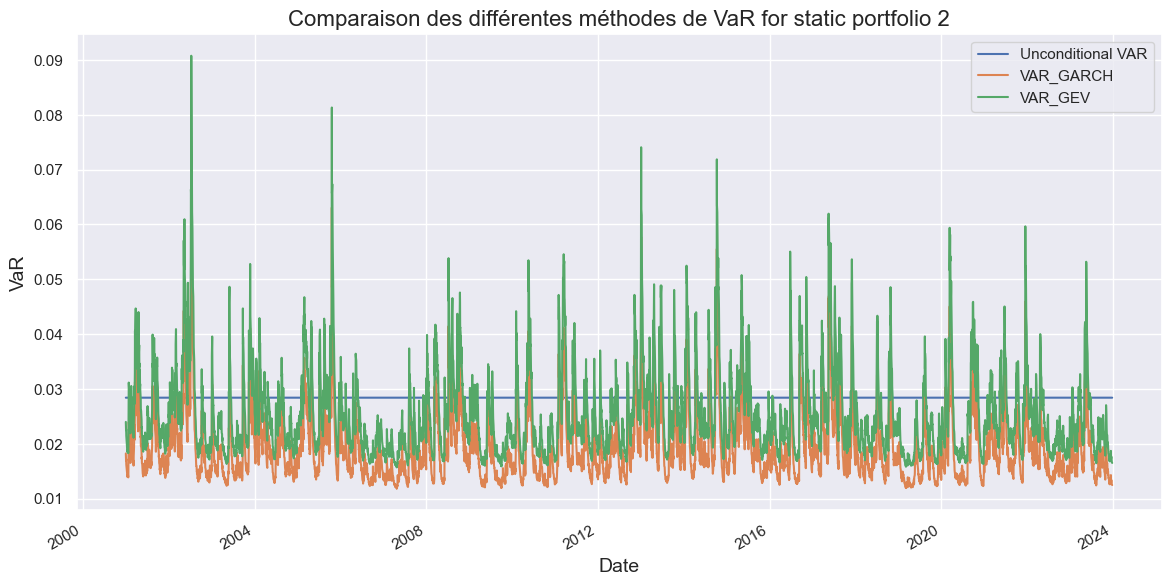

In [121]:
fig, ax = plt.subplots(figsize=(14, 7))  

ax.plot(static_results2['Date'], static_results2['Unconditional VAR'], label='Unconditional VAR', linewidth=1.5)
ax.plot(static_results2['Date'], static_results2['VAR_GARCH'], label='VAR_GARCH', linewidth=1.5)
ax.plot(static_results2['Date'], static_results2['VAR_GEV'], label='VAR_GEV', linewidth=1.5)

ax.set_title('Comparaison des différentes méthodes de VaR for static portfolio 2', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('VaR', fontsize=14)
ax.legend()

plt.gcf().autofmt_xdate()  

plt.show()


In [117]:
sigma_p_t1 = np.sqrt(sigma2_p_t1)


var_gev_s10 = mu_p_t1 + q99_zt_s10*sigma_p_t1

static_results10 = pd.DataFrame({
    'Date': static_dpr_loss2.index,
    'Unconditional VAR':VaR_99_s10,
    'VAR_GARCH': conditional_VaR_99,
    'VAR_GEV' : var_gev_s10
})

static_results10

,Date,Unconditional VAR,VAR_GARCH,VAR_GEV
0,2001-01-01,0.005689,0.018235,0.024739
1,2001-01-02,0.005689,0.017449,0.023777
2,2001-01-03,0.005689,0.016945,0.023204
3,2001-01-04,0.005689,0.017240,0.023294
4,2001-01-05,0.005689,0.016209,0.022140
...,...,...,...,...
5991,2023-12-19,0.005689,0.013020,0.017783
5992,2023-12-20,0.005689,0.012897,0.017599
5993,2023-12-21,0.005689,0.012780,0.017427
5994,2023-12-22,0.005689,0.012571,0.017169


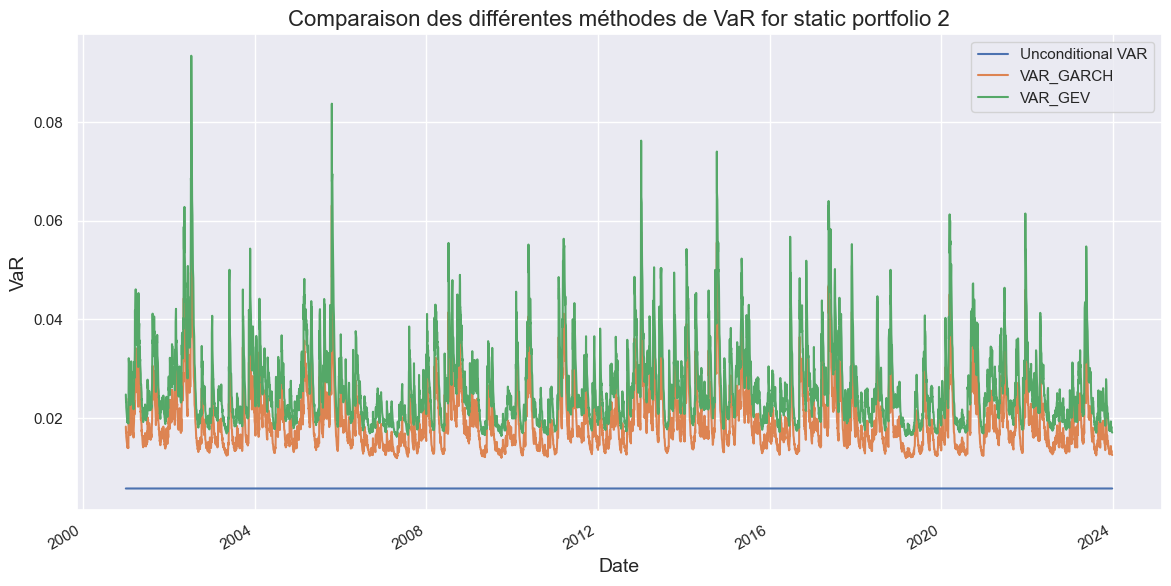

In [122]:
fig, ax = plt.subplots(figsize=(14, 7))  

ax.plot(static_results10['Date'], static_results10['Unconditional VAR'], label='Unconditional VAR', linewidth=1.5)
ax.plot(static_results10['Date'], static_results10['VAR_GARCH'], label='VAR_GARCH', linewidth=1.5)
ax.plot(static_results10['Date'], static_results10['VAR_GEV'], label='VAR_GEV', linewidth=1.5)

ax.set_title('Comparaison des différentes méthodes de VaR for static portfolio 2', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('VaR', fontsize=14)
ax.legend()

plt.gcf().autofmt_xdate()  

plt.show()


In [118]:
sigma_p_t1 = np.sqrt(sigma2_p_t1)


var_gev_d2 = mu_p_t1 + q99_zt_d2*sigma_p_t1

dyn_result_2 = pd.DataFrame({
    'Date': dynnamic_dpr_loss2.index,
    'Unconditional VAR':VaR_99_d2,
    'VAR_GARCH': conditional_VaR_99,
    'VAR_GEV' : var_gev_d2
})

dyn_result_2

,Date,Unconditional VAR,VAR_GARCH,VAR_GEV
0,2001-01-01,0.090411,0.018235,0.101695
1,2001-01-02,0.090411,0.017449,0.098644
2,2001-01-03,0.090411,0.016945,0.097251
3,2001-01-04,0.090411,0.017240,0.094916
4,2001-01-05,0.090411,0.016209,0.092309
...,...,...,...,...
5991,2023-12-19,0.090411,0.013020,0.074136
5992,2023-12-20,0.090411,0.012897,0.073228
5993,2023-12-21,0.090411,0.012780,0.072413
5994,2023-12-22,0.090411,0.012571,0.071572


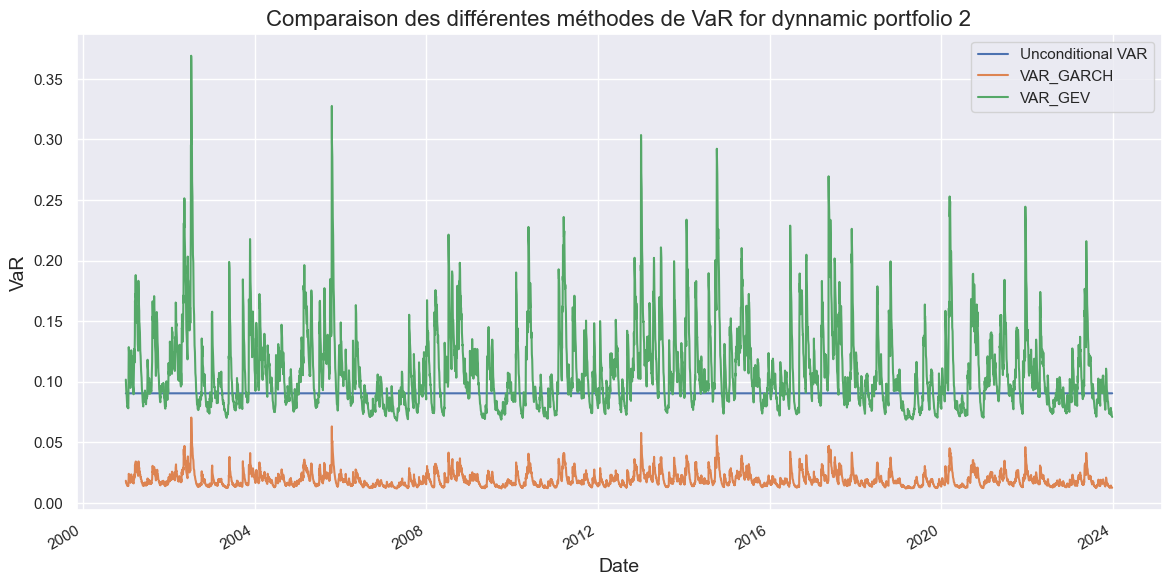

In [125]:
fig, ax = plt.subplots(figsize=(14, 7))  

ax.plot(dyn_result_2['Date'], dyn_result_2['Unconditional VAR'], label='Unconditional VAR', linewidth=1.5)
ax.plot(dyn_result_2['Date'], dyn_result_2['VAR_GARCH'], label='VAR_GARCH', linewidth=1.5)
ax.plot(dyn_result_2['Date'], dyn_result_2['VAR_GEV'], label='VAR_GEV', linewidth=1.5)

ax.set_title('Comparaison des différentes méthodes de VaR for dynnamic portfolio 2', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('VaR', fontsize=14)
ax.legend()

plt.gcf().autofmt_xdate()  

plt.show()


In [113]:
sigma_p_t1 = np.sqrt(sigma2_p_t1)


var_gev_d10 = mu_p_t1 + q99_zt_d10*sigma_p_t1

dyn_result_10 = pd.DataFrame({
    'Date': dynnamic_dpr_loss2.index,
    'Unconditional VAR':VaR_99_d10,
    'VAR_GARCH': conditional_VaR_99,
    'VAR_GEV' : var_gev_d10
})

dyn_result_10

,Date,Unconditional VAR,VAR_GARCH,VAR_GEV
0,2001-01-01,0.018045,0.018235,0.102162
1,2001-01-02,0.018045,0.017449,0.099097
2,2001-01-03,0.018045,0.016945,0.097700
3,2001-01-04,0.018045,0.017240,0.095350
4,2001-01-05,0.018045,0.016209,0.092734
...,...,...,...,...
5991,2023-12-19,0.018045,0.013020,0.074477
5992,2023-12-20,0.018045,0.012897,0.073565
5993,2023-12-21,0.018045,0.012780,0.072746
5994,2023-12-22,0.018045,0.012571,0.071902


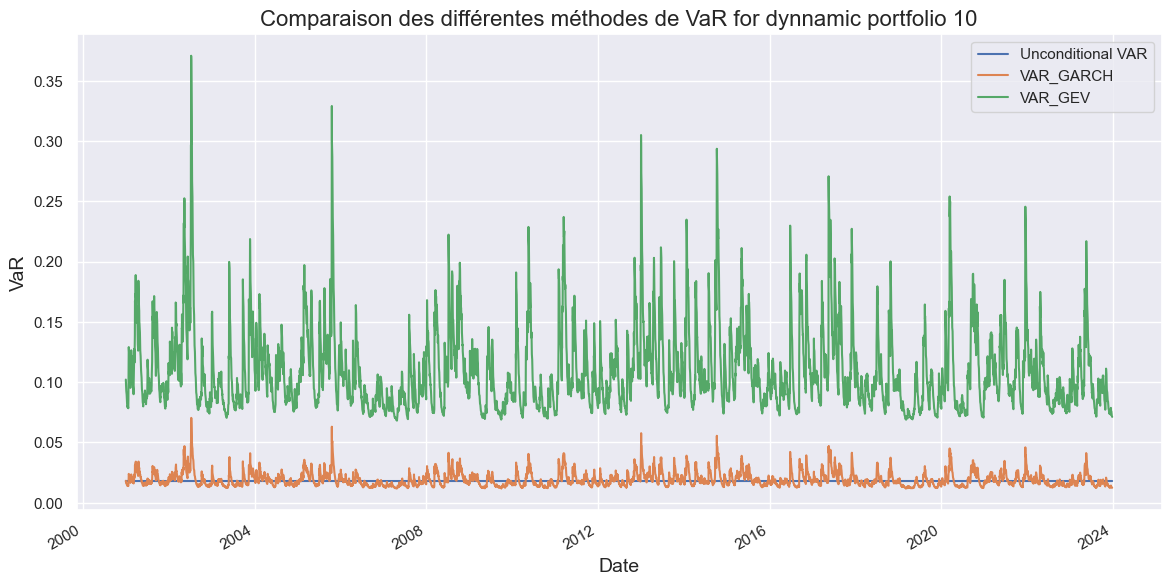

In [126]:
fig, ax = plt.subplots(figsize=(14, 7))  

ax.plot(dyn_result_10['Date'], dyn_result_10['Unconditional VAR'], label='Unconditional VAR', linewidth=1.5)
ax.plot(dyn_result_10['Date'], dyn_result_10['VAR_GARCH'], label='VAR_GARCH', linewidth=1.5)
ax.plot(dyn_result_10['Date'], dyn_result_10['VAR_GEV'], label='VAR_GEV', linewidth=1.5)

ax.set_title('Comparaison des différentes méthodes de VaR for dynnamic portfolio 10', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('VaR', fontsize=14)
ax.legend()

plt.gcf().autofmt_xdate()  

plt.show()
